# BTC-USD @24h

In [1]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
STOCKS = [
    'sp500',
    'amd',
    'nvda',
    'gbtc',
    'mara',
    'ostk',
    'otiv',
    'riot',
    'sieb',
]
STOCKS_FILENAMES = {s: './data_clean/' + s + '.csv'
                    for s in STOCKS}
# OUT_FILENAME = './results/'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [4]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> BTC-USD: 1324 data points
  from 2015-02-28 00:00:00 to 2018-10-13 00:00:00


close   open   high    low  volume  missing
datetime                                               
2015-02-28  253.0  253.1  254.3  245.2    3.61        0

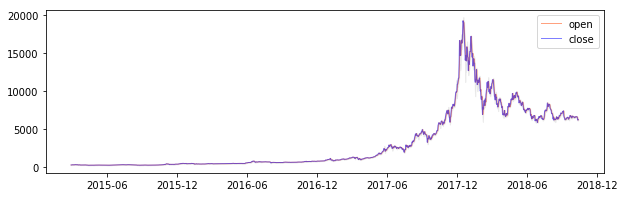

In [5]:
data_btc = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
data_btc = data_btc[data_btc.index >= '2015-02-28']
print("> BTC-USD: %d data points" % (len(data_btc),))
print("  from %s to %s" % (data_btc.iloc[0].name, data_btc.iloc[-1].name))
simple_plot(data_btc, show_xlabels=False)
dd(data_btc.head(1))



---------
> stock OSTK: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close    volume  open  high    low  missing  weekday
datetime                                                        
2015-03-02  23.86  177195.0  22.7  23.9  22.52      0.0        0

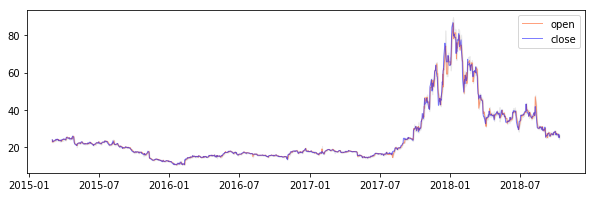



---------
> stock RIOT: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close    volume  open  high   low  missing  weekday
datetime                                                       
2015-03-02   4.44  158462.0   4.4  4.88  4.32      0.0        0

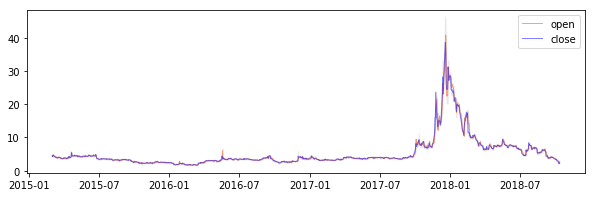



---------
> stock AMD: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close      volume  open  high   low  missing  weekday
datetime                                                         
2015-03-02   3.21  15629320.0  3.13  3.23  3.11      0.0        0

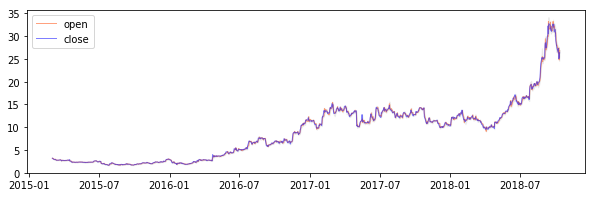



---------
> stock GBTC: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close  volume    open    high     low  missing  weekday
datetime                                                            
2015-03-02  0.2088     0.0  0.2088  0.2088  0.2088      0.0        0

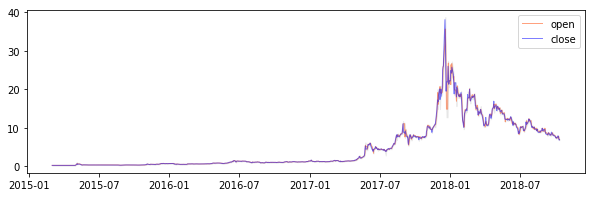



---------
> stock NVDA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     volume  open   high     low  missing  weekday
datetime                                                            
2015-03-02  22.595  7536531.0  22.0  22.72  21.971      0.0        0

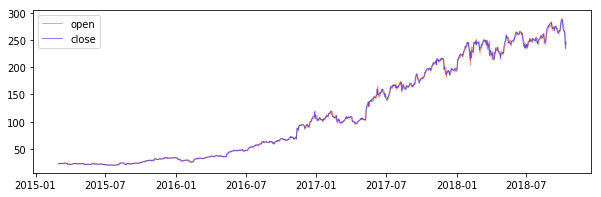



---------
> stock SIEB: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close  volume  open  high   low  missing  weekday
datetime                                                     
2015-03-02   1.68  4320.0  1.62  1.68  1.61      0.0        0

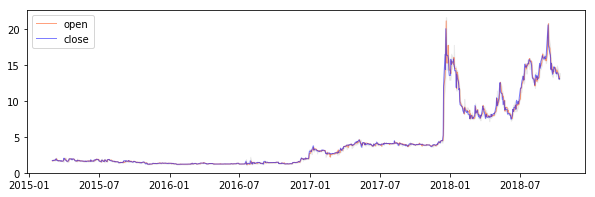



---------
> stock OTIV: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close    volume  open  high   low  missing  weekday
datetime                                                       
2015-03-02   1.32  153286.0  1.25  1.33  1.25      0.0        0

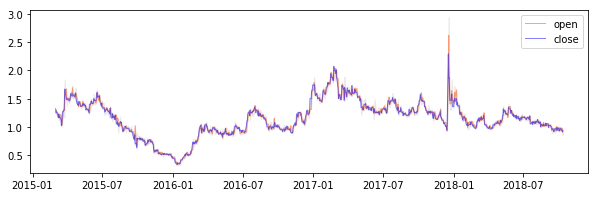



---------
> stock SP500: 914 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     open     high     low  volume  missing  weekday
datetime                                                               
2015-03-02  2117.39  2105.23  2117.52  2104.5     NaN        0        0

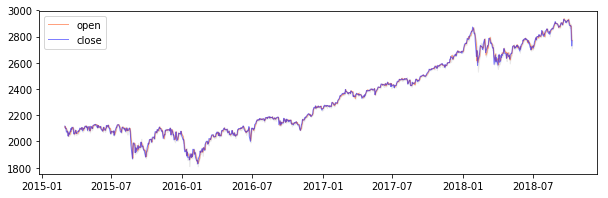



---------
> stock MARA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close   volume   open    high    low  missing  weekday
datetime                                                          
2015-03-02  29.88  40587.0  29.76  30.576  29.28      0.0        0

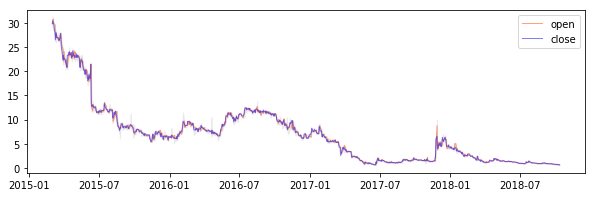

In [6]:
stocks_data = {}
for stock, filename in STOCKS_FILENAMES.items():
    data = pd.read_csv(
        filename,
        index_col='datetime',
        parse_dates=['datetime']
    )
    data = data[data.index >= '2015-02-28']
    data['weekday'] = data.index.dayofweek
    stocks_data[stock] = data
    print("\n\n---------")
    print("> stock %s: %d data points" % (stock.upper(), len(data)))
    print("  from %s to %s" % (data.iloc[0].name, data.iloc[-1].name))
    dd(data.head(1))
    simple_plot(data, show_xlabels=False)
    plt.show()

## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** Best results at 6 epochs .



        #################################
        # ostk
        #################################
        
data ~ (900, 6)
--- 0.020s to model compilation time


--- Created model id: 140537065049616
Tensor("lstm_305_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_305 (LSTM)              (None, 7, 4)              176       
_________________________________________________________________
dropout_305 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_306 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_306 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 4         
Total params

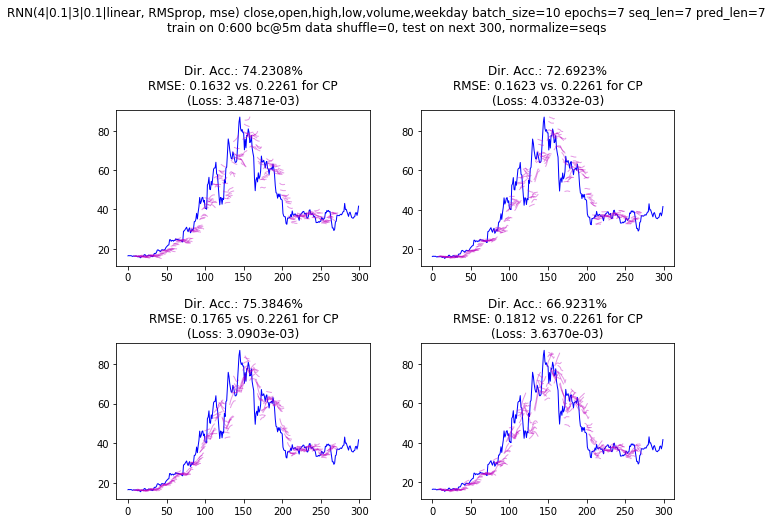

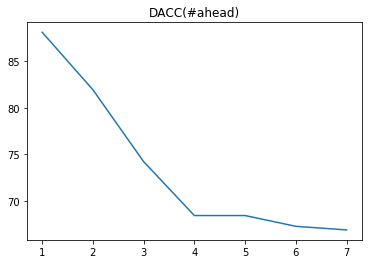

--- 188.829s to run experiment



In [35]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday'],
            from_i=0,
            train_sz=600,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor(
                [4, 0.1, 3, 0.1]
            ),
            # training:
            epochs=7,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break



        #################################
        # ostk
        #################################
        
data ~ (600, 6)
--- 0.014s to model compilation time


--- Created model id: 140541198766544
Tensor("lstm_1_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 

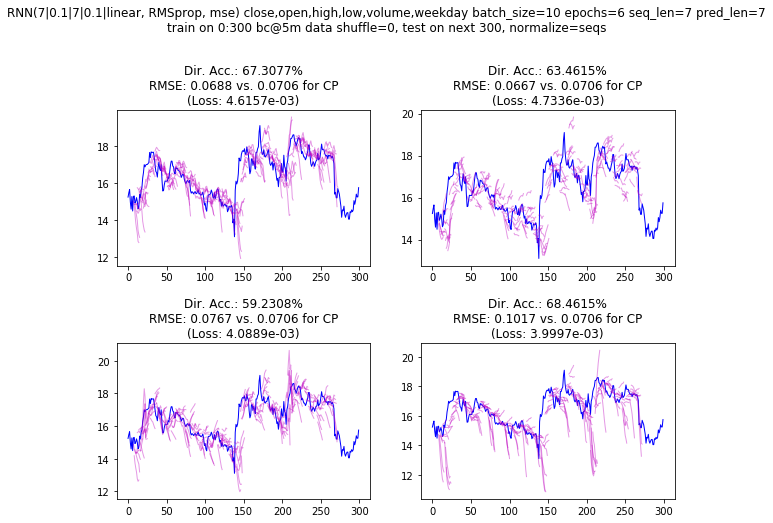

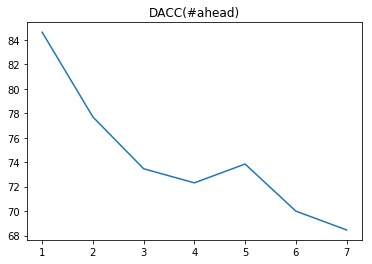

--- 19.345s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 6)
--- 0.015s to model compilation time


--- Created model id: 140540477610768
Tensor("lstm_9_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_10 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)           

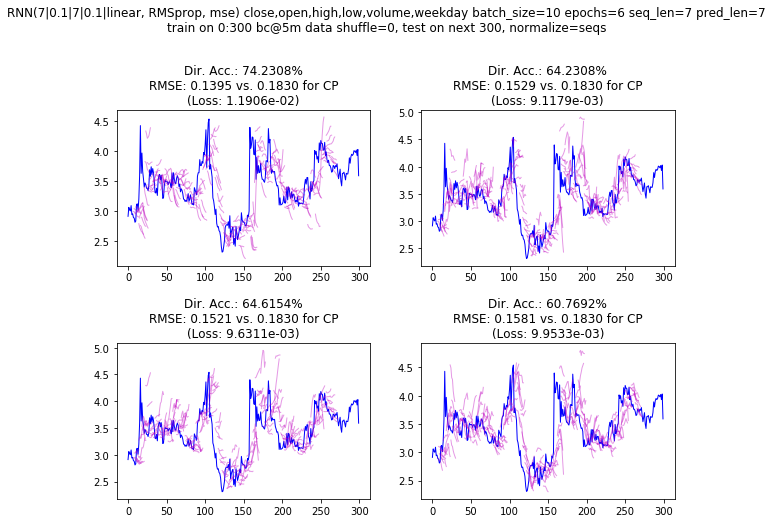

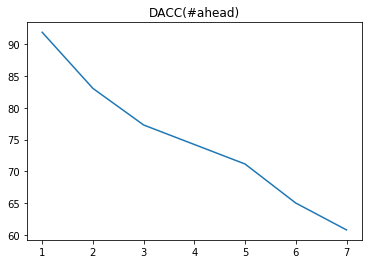

--- 22.783s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140539308314000
Tensor("lstm_17_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_18 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)           

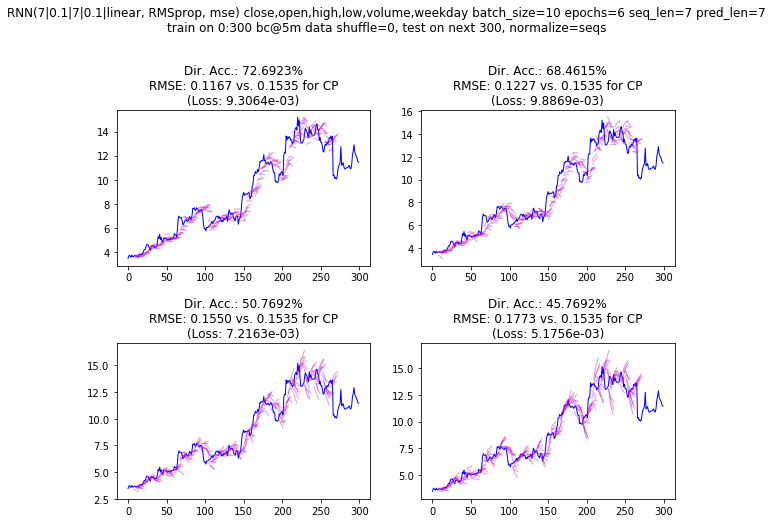

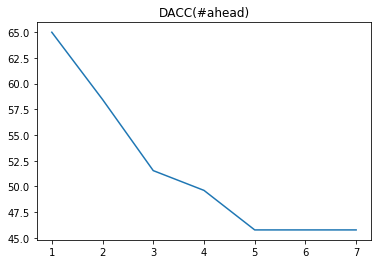

--- 26.378s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 6)
--- 0.014s to model compilation time


--- Created model id: 140539228369168
Tensor("lstm_25_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_26 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)          

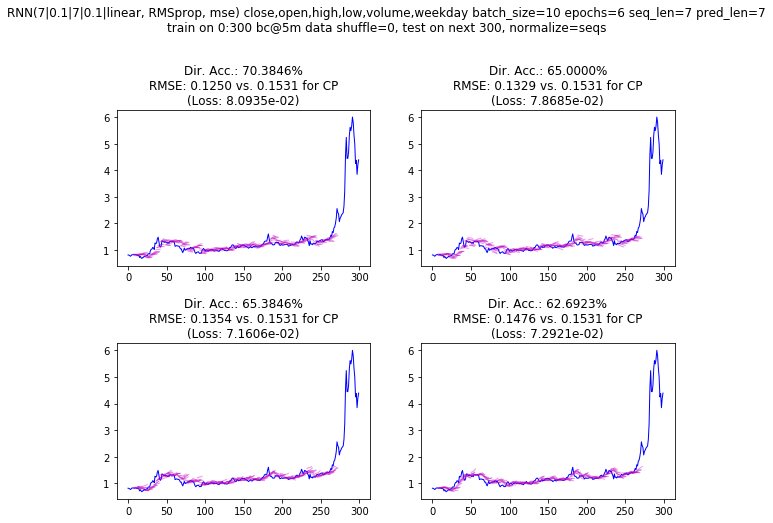

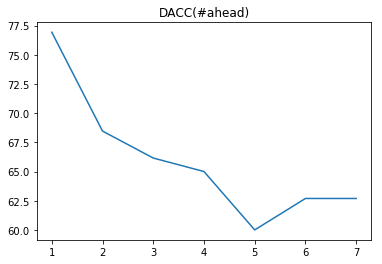

--- 29.695s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 6)
--- 0.022s to model compilation time


--- Created model id: 140539157234896
Tensor("lstm_33_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_33 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_34 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)          

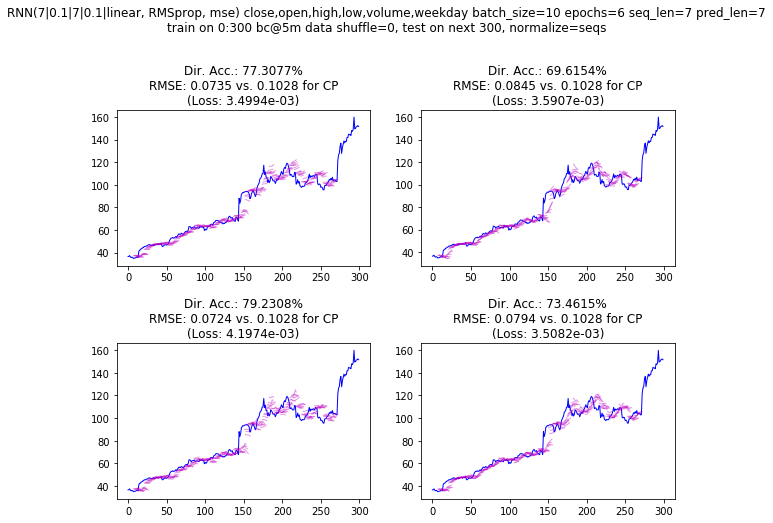

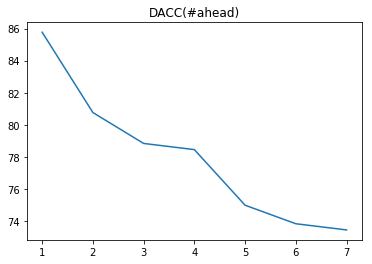

--- 36.887s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 6)
--- 0.026s to model compilation time


--- Created model id: 140539087416400
Tensor("lstm_41_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_41 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_42 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)          

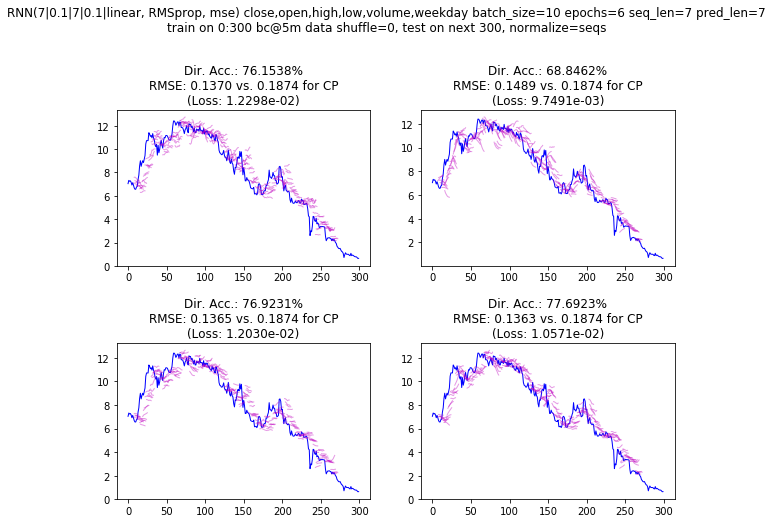

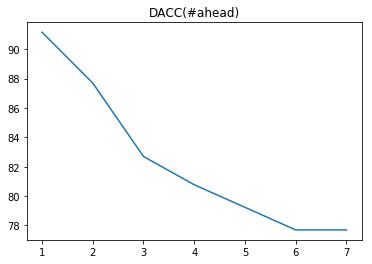

--- 42.275s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 6)
--- 0.023s to model compilation time


--- Created model id: 140539015523856
Tensor("lstm_49_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_49 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_50 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)          

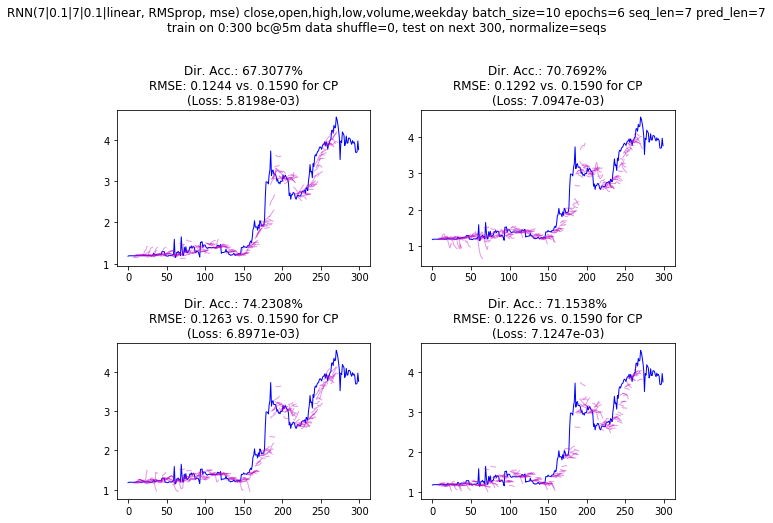

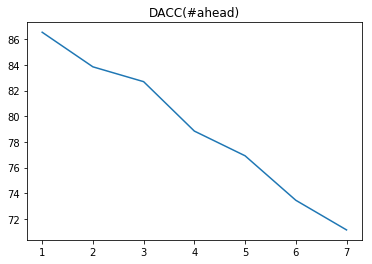

--- 44.518s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 6)


AssertionError: nan != 0.000000

In [7]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
            # training:
            epochs=6,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140538943414672
Tensor("lstm_57_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_57 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_58 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 8         
Total params:

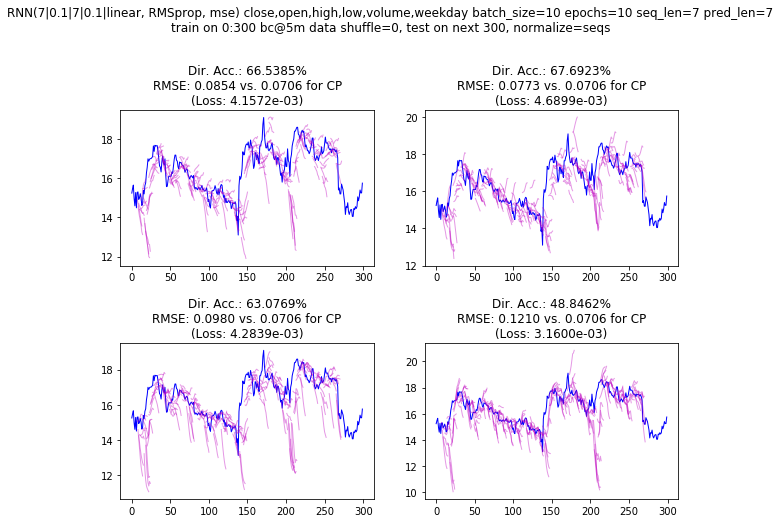

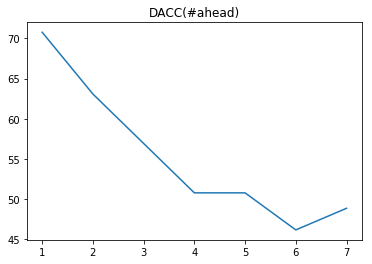

--- 47.630s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140538857864720
Tensor("lstm_65_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_65 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_66 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)          

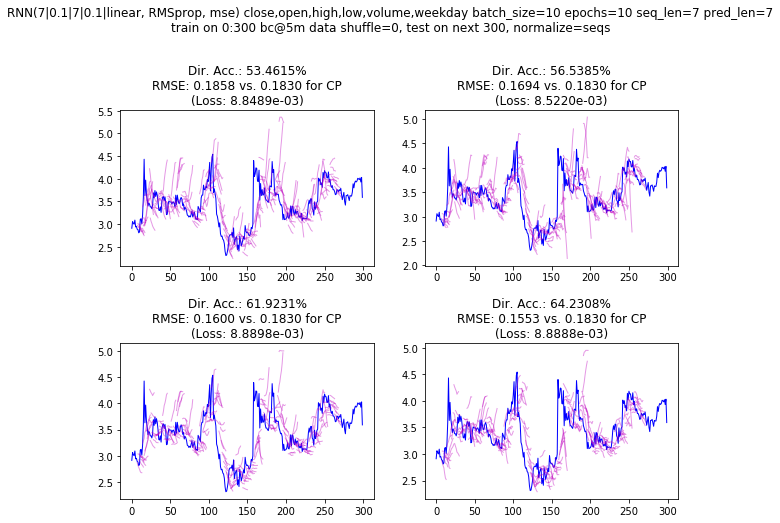

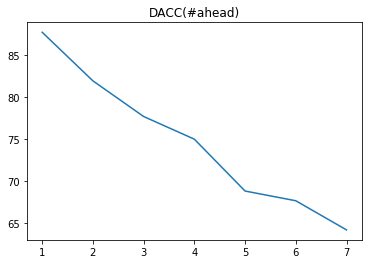

--- 51.108s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 6)
--- 0.014s to model compilation time


--- Created model id: 140538806839120
Tensor("lstm_73_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_73 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_74 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)           

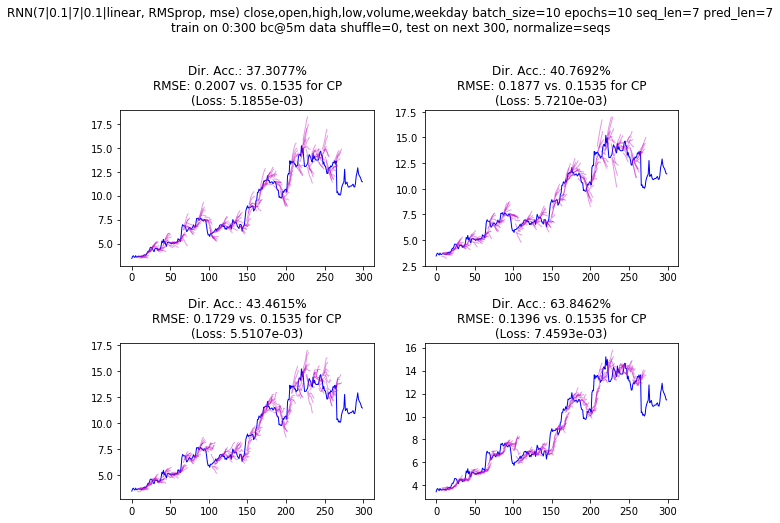

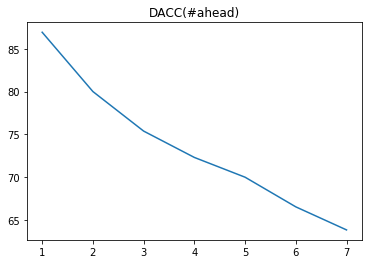

--- 53.604s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140538723255568
Tensor("lstm_81_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_81 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_82 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)          

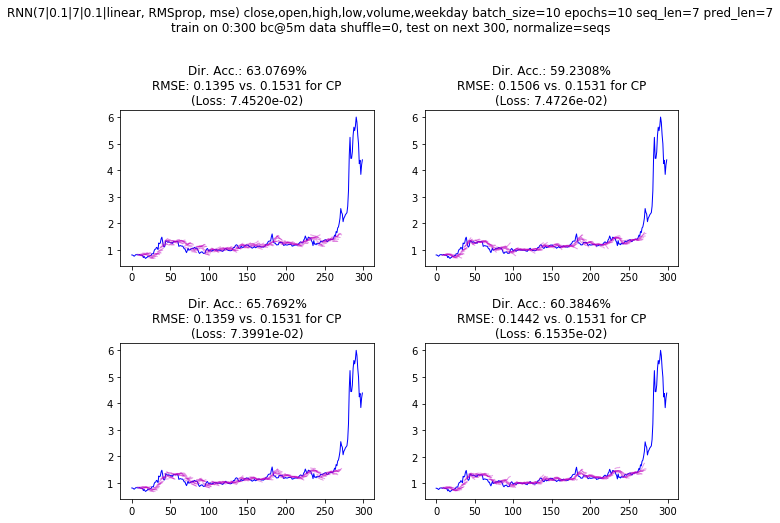

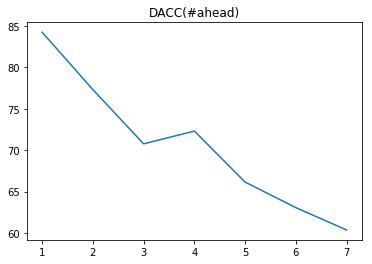

--- 59.023s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 6)
--- 0.015s to model compilation time


--- Created model id: 140538669431696
Tensor("lstm_89_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_89 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_90 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)          

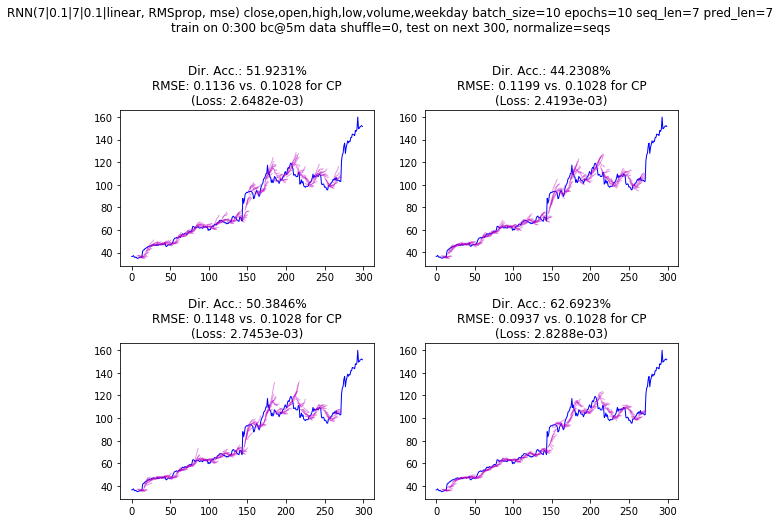

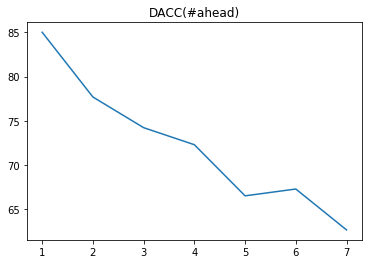

--- 60.481s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140538581967184
Tensor("lstm_97_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_97 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_98 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)          

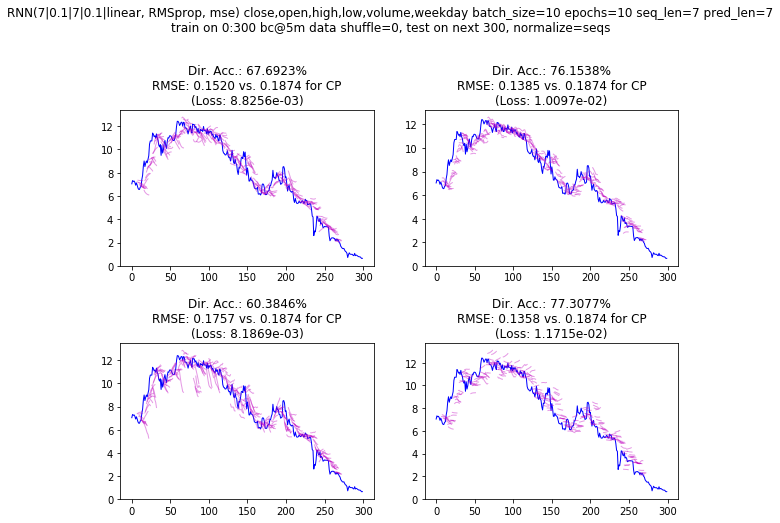

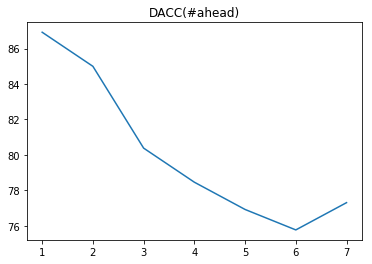

--- 66.080s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140538530307088
Tensor("lstm_105_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_105 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_105 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_106 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_106 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)         

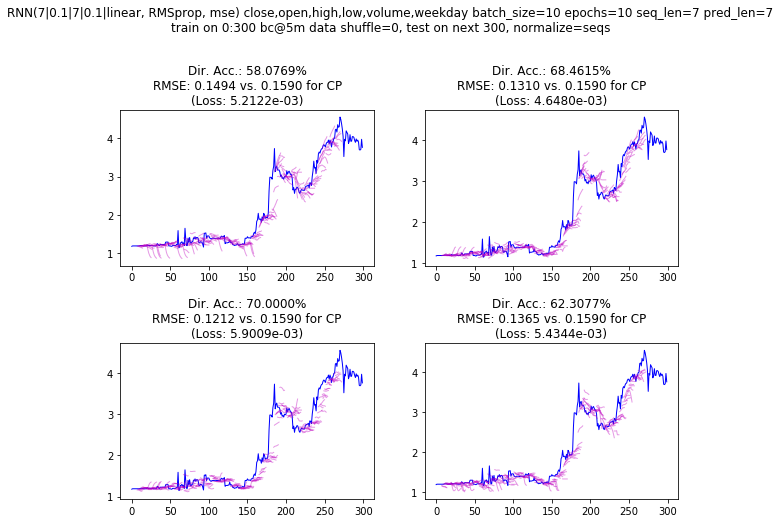

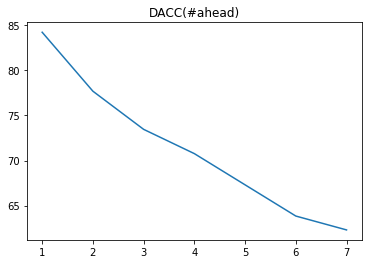

--- 69.684s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 6)


AssertionError: nan != 0.000000

In [8]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
            # training:
            epochs=10,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )

### 3|0.1|3|0.1

**Conclusion:** 3 epochs best.



        #################################
        # ostk
        #################################
        
data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140542293080272
Tensor("lstm_113_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_113 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_113 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_114 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_114 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 4         
Total params

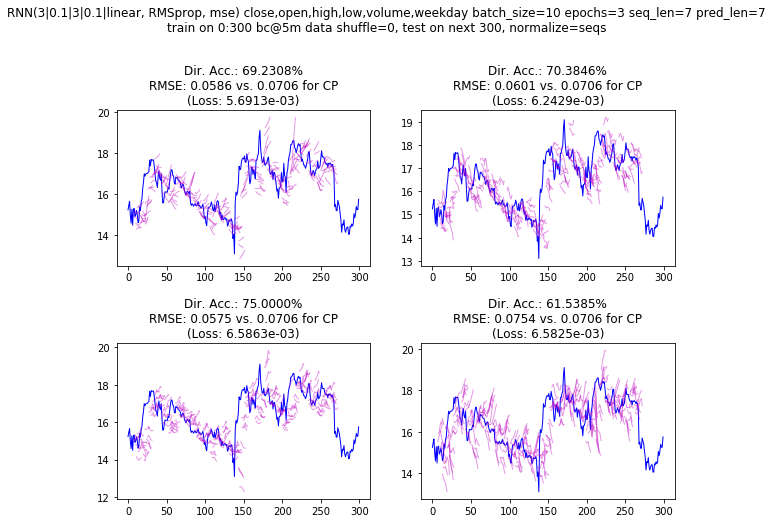

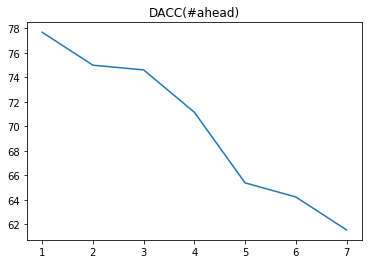

--- 69.892s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140538352005456
Tensor("lstm_121_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_121 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_121 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_122 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_122 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)         

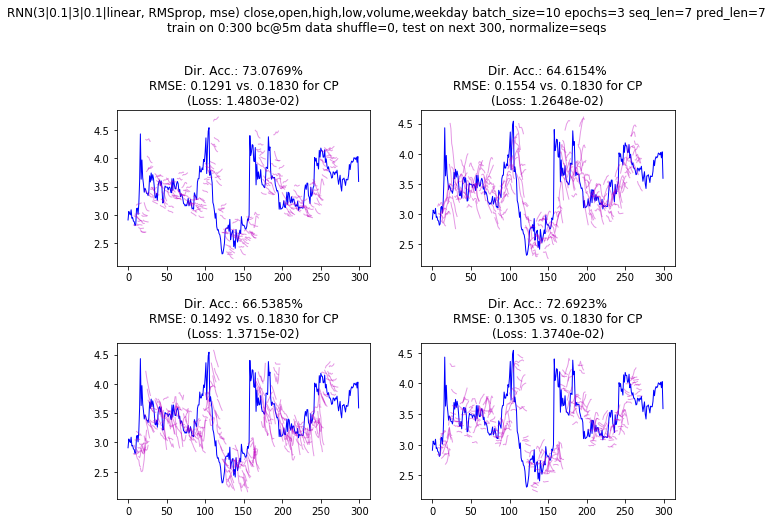

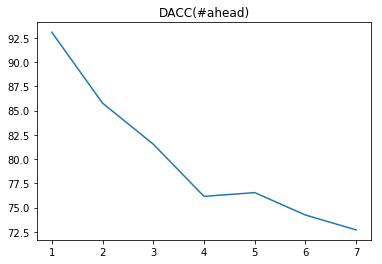

--- 77.693s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 6)
--- 0.018s to model compilation time


--- Created model id: 140538314590672
Tensor("lstm_129_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_129 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_129 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_130 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_130 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)          

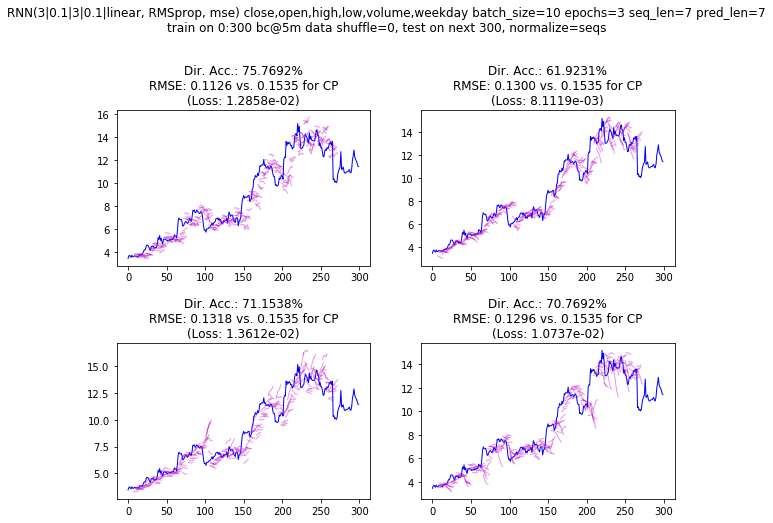

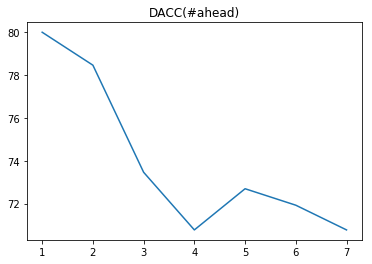

--- 80.482s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140538229533648
Tensor("lstm_137_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_137 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_137 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_138 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_138 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)         

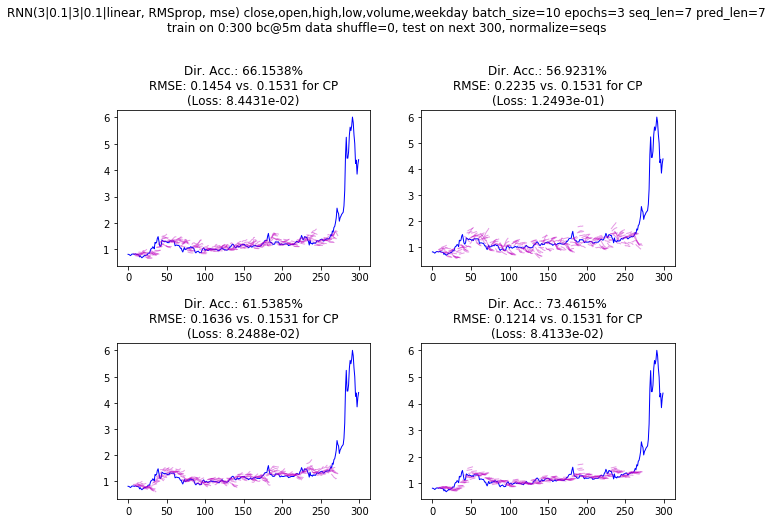

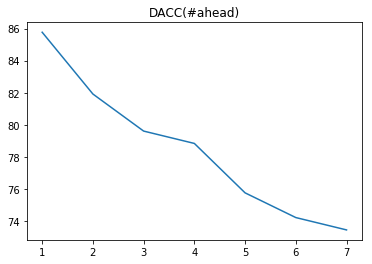

--- 81.525s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140538140975632
Tensor("lstm_145_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_145 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_145 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_146 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_146 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)         

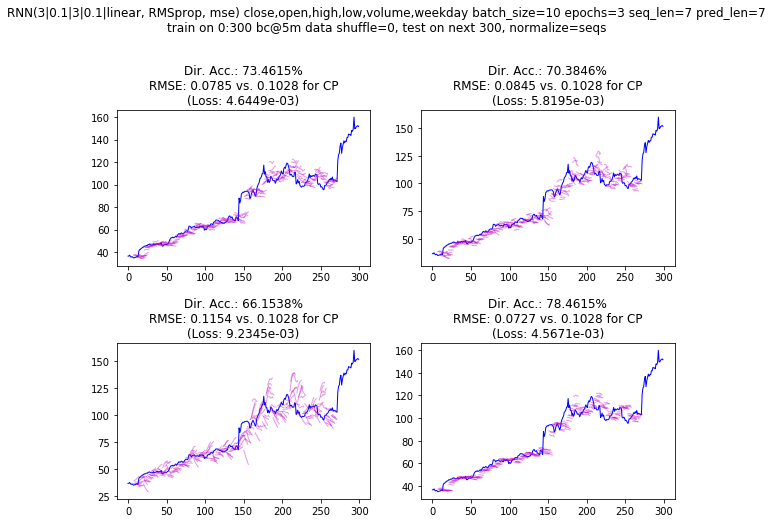

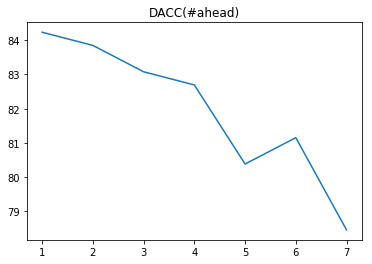

--- 88.031s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140538104795536
Tensor("lstm_153_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_153 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_153 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_154 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_154 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)         

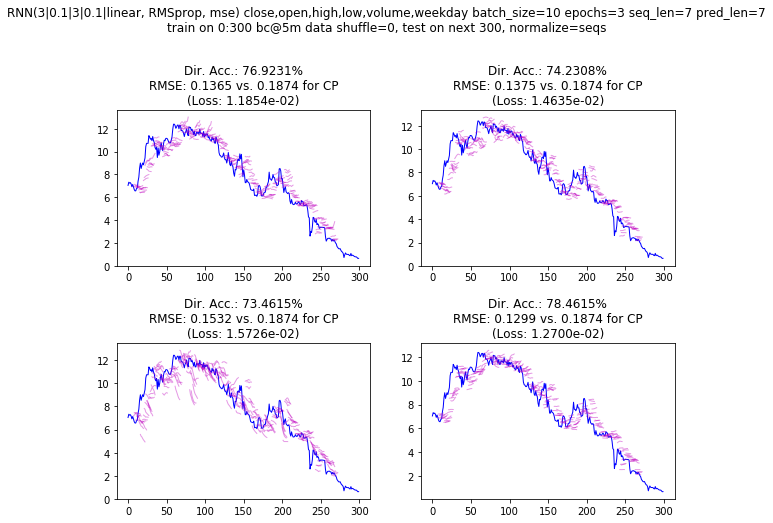

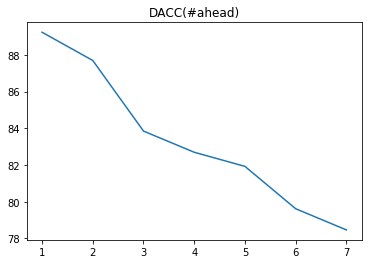

--- 90.411s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140538017584336
Tensor("lstm_161_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_161 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_161 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_162 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_162 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)         

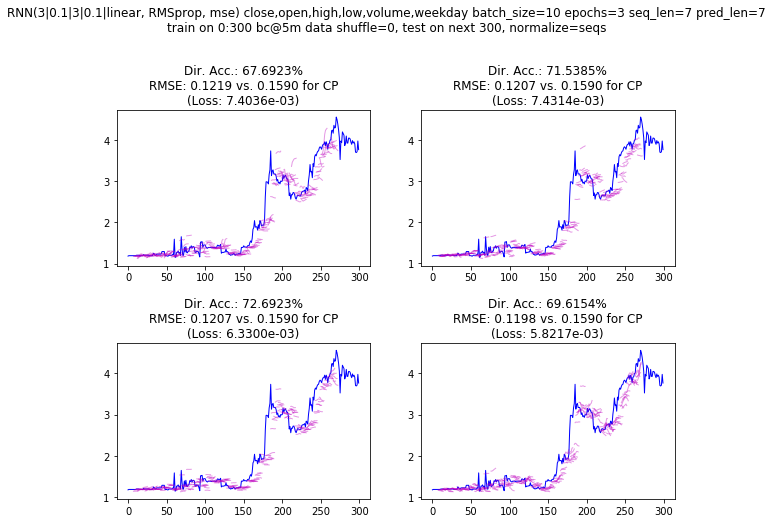

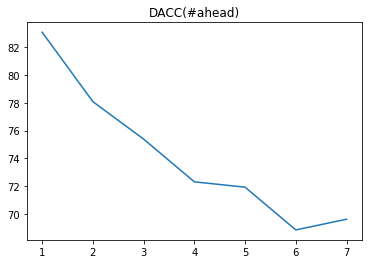

--- 92.706s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 6)


AssertionError: nan != 0.000000

In [9]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=3,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140538943416016
Tensor("lstm_169_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_169 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_169 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_170 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_170 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 4         
Total params

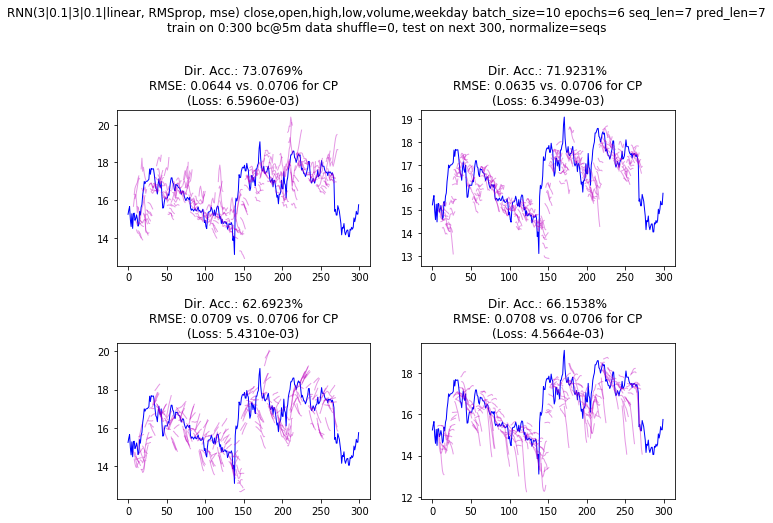

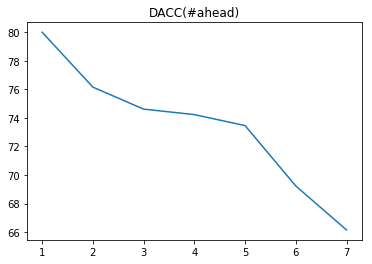

--- 102.449s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140537842274576
Tensor("lstm_177_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_177 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_177 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_178 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_178 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)        

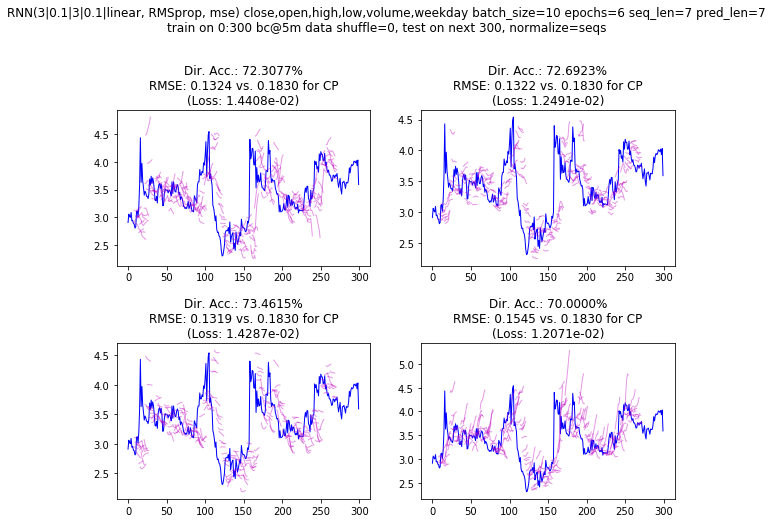

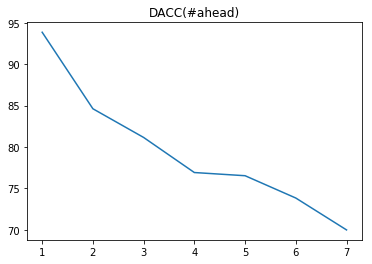

--- 112.222s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140537996352528
Tensor("lstm_185_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_185 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_185 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_186 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_186 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)         

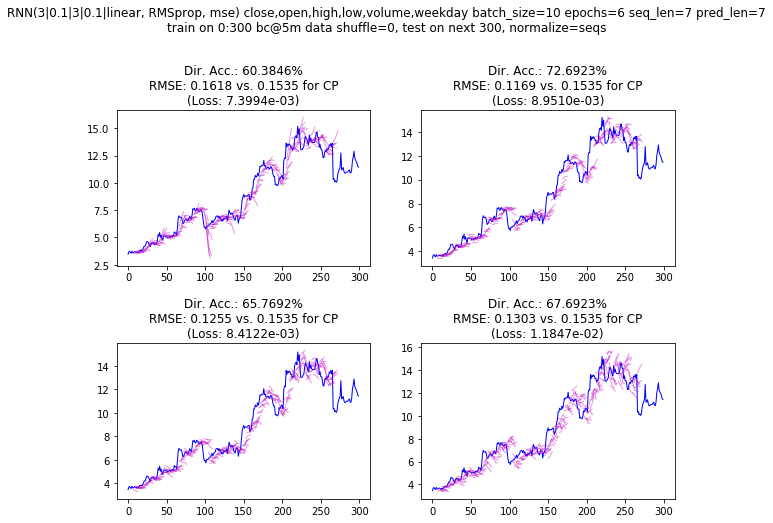

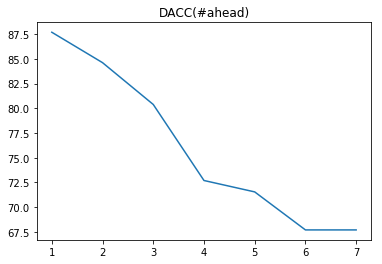

--- 113.902s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140537734566928
Tensor("lstm_193_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_193 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_193 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_194 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_194 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_97 (Dense)             (None, 1)        

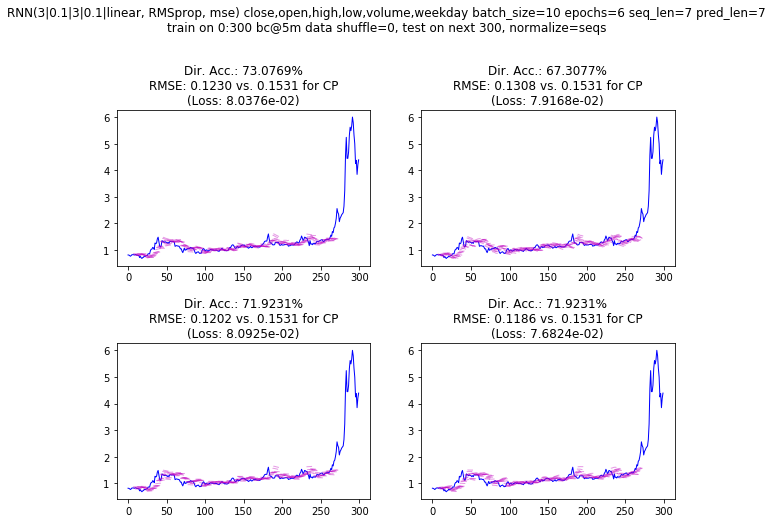

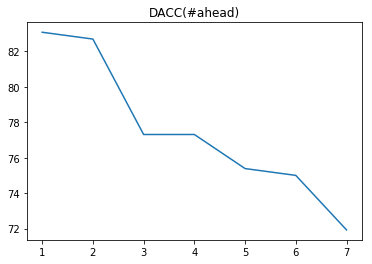

--- 116.390s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140537646946064
Tensor("lstm_201_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_201 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_201 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_202 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_202 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)        

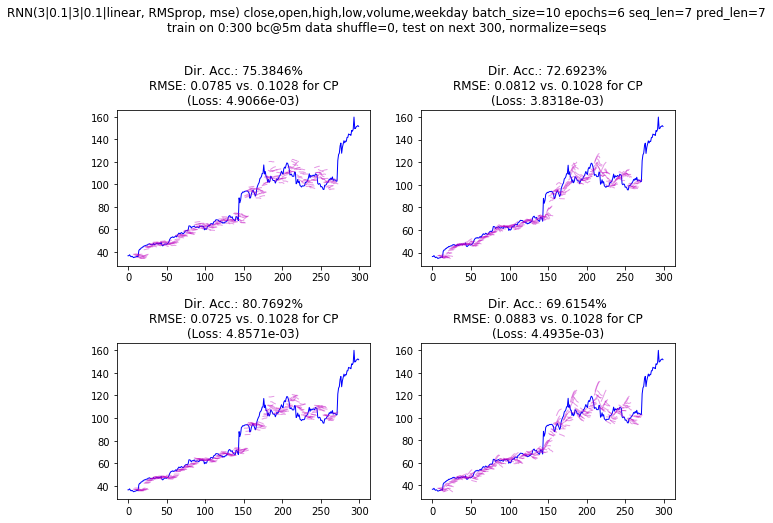

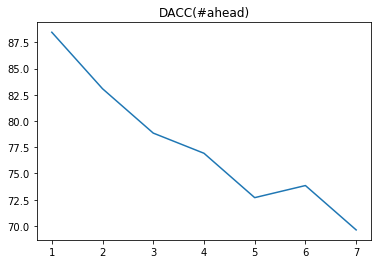

--- 121.609s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 6)
--- 0.018s to model compilation time


--- Created model id: 140537559104912
Tensor("lstm_209_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_209 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_209 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_210 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_210 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_105 (Dense)            (None, 1)        

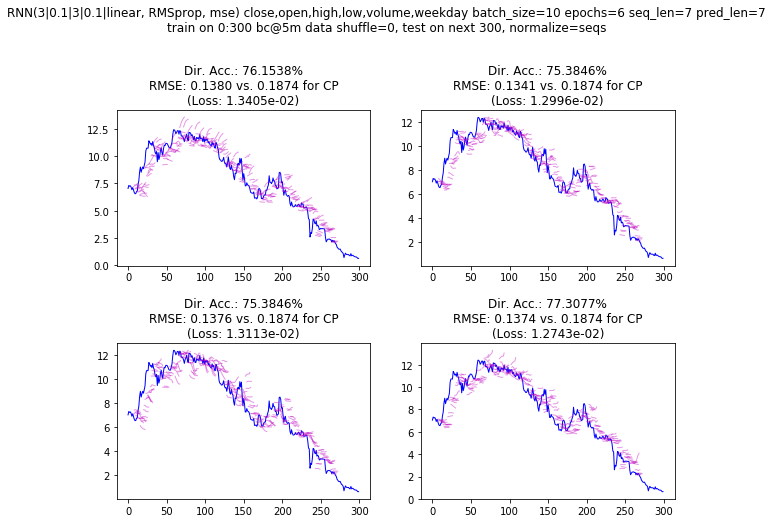

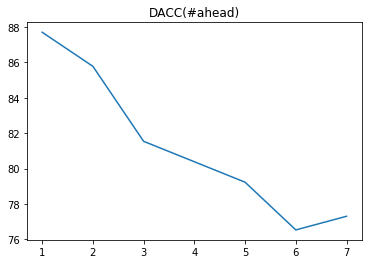

--- 125.314s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140537469453072
Tensor("lstm_217_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_217 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_217 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_218 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_218 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_109 (Dense)            (None, 1)        

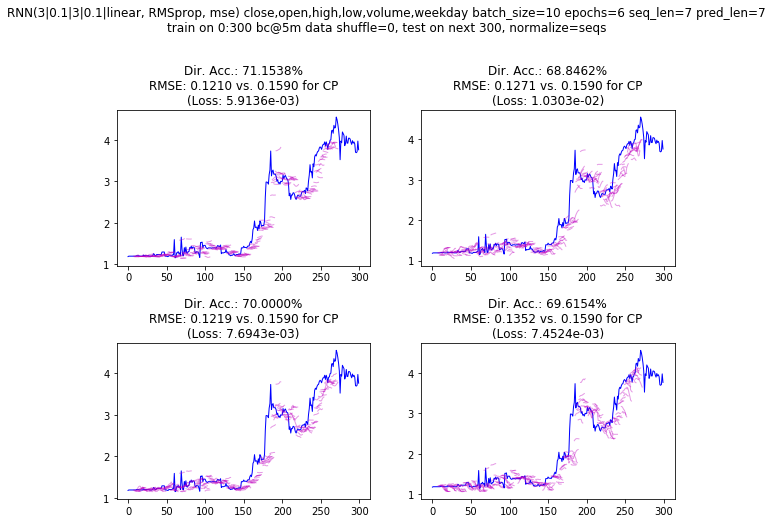

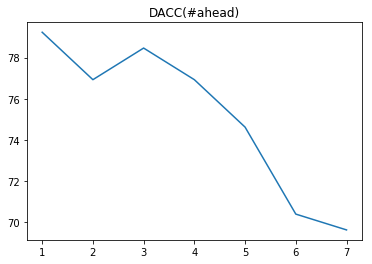

--- 140.248s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 6)


AssertionError: nan != 0.000000

In [10]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=6,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (600, 6)
--- 0.021s to model compilation time


--- Created model id: 140535945278160
Tensor("lstm_401_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_401 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_401 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_402 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_402 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 4         
Total params

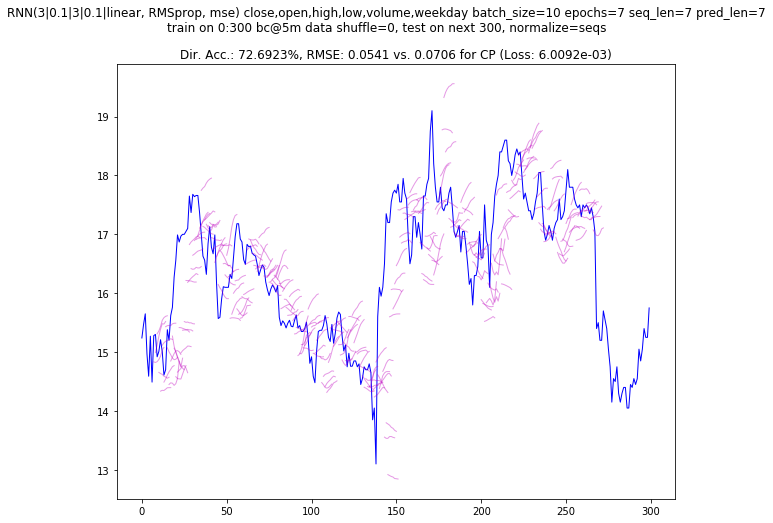

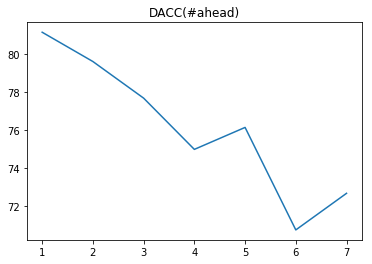

--- 60.519s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 6)
--- 0.021s to model compilation time


--- Created model id: 140535890672720
Tensor("lstm_403_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_403 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_403 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_404 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_404 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_202 (Dense)            (None, 1)         

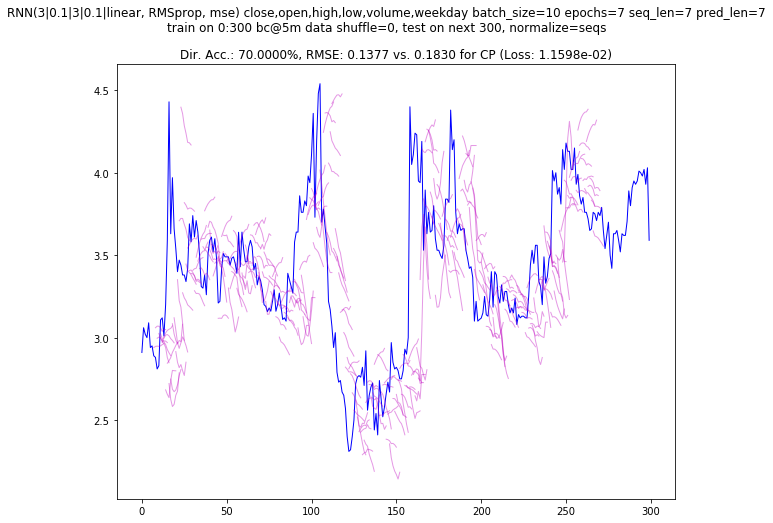

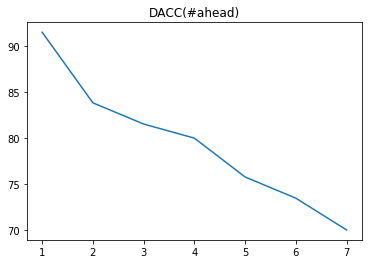

--- 64.010s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 6)
--- 0.033s to model compilation time


--- Created model id: 140535829463248
Tensor("lstm_405_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_405 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_405 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_406 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_406 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_203 (Dense)            (None, 1)          

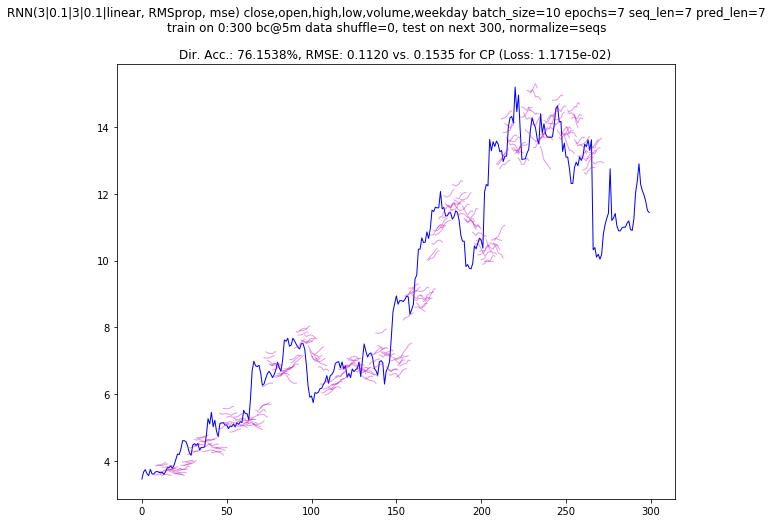

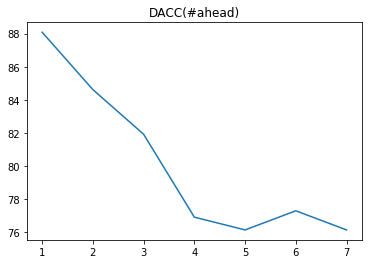

--- 65.501s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140535806630864
Tensor("lstm_407_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_407 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_407 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_408 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_408 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_204 (Dense)            (None, 1)         

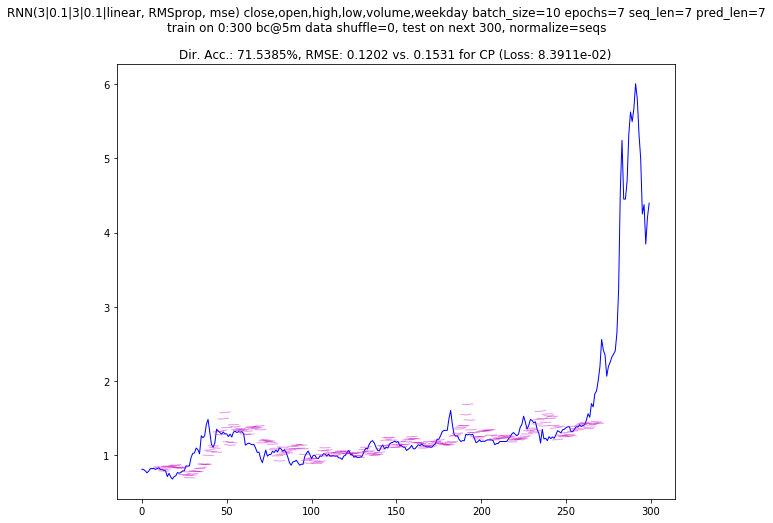

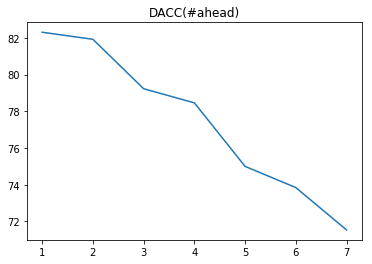

--- 65.488s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 6)
--- 0.021s to model compilation time


--- Created model id: 140535783917072
Tensor("lstm_409_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_409 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_409 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_410 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_410 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_205 (Dense)            (None, 1)         

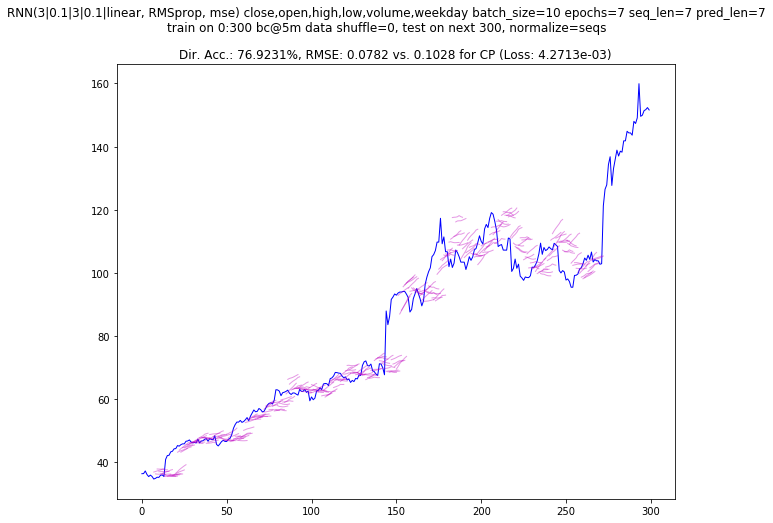

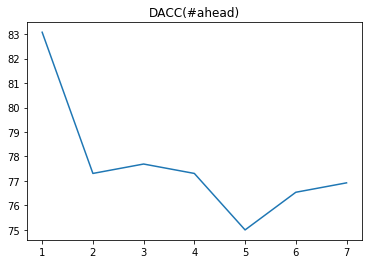

--- 64.511s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 6)
--- 0.021s to model compilation time


--- Created model id: 140535760323152
Tensor("lstm_411_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_411 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_411 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_412 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_412 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_206 (Dense)            (None, 1)         

KeyboardInterrupt: 

<Figure size 720x576 with 0 Axes>

In [54]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=7,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=1,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )

## Full runs

In [8]:
DEFAULT_PARAMS = {
    # data to extract:
    'features': ['close', 'open', 'high', 'low', 'volume',
                 'weekday'],
    'train_sz': 600,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([4, 0.1, 3, 0.1]),
    # training:
    'epochs': 7,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [9]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [10]:
def full_run(idx_from, idx_to, data, out_filename, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(out_filename, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          data_df=data,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()



        #################################
        # ostk
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 6)
--- 0.021s to model compilation time


--- Created model id: 140536371783312
Tensor("lstm_349_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_349 (LSTM)              (None, 7, 4)              176       
_________________________________________________________________
dropout_349 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_350 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_350 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_175 (Dense)     

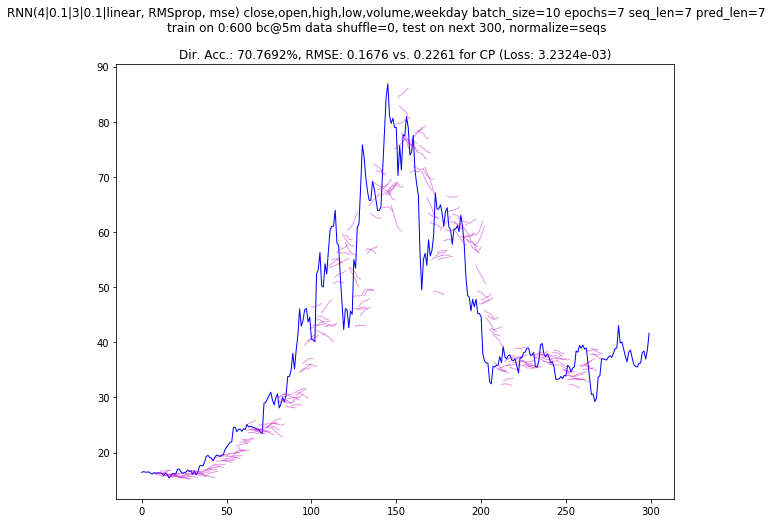

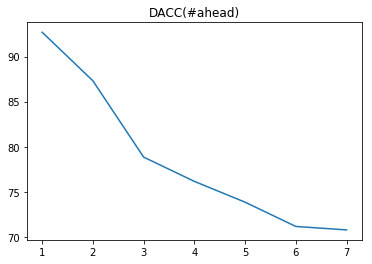

--- 56.852s to run segment

--- 56.853s to full run 600 - 645



        #################################
        # riot
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 6)
--- 0.022s to model compilation time


--- Created model id: 140536284303312
Tensor("lstm_351_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_351 (LSTM)              (None, 7, 4)              176       
_________________________________________________________________
dropout_351 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_352 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_352 (Dropout)        (None, 3)                 0         
_________________________

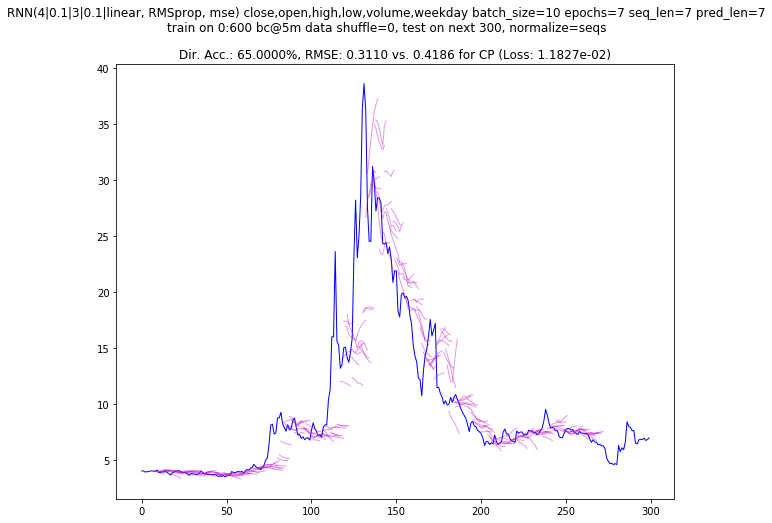

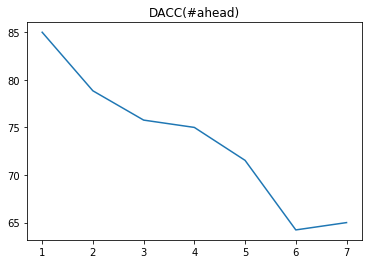

--- 57.258s to run segment

--- 57.258s to full run 600 - 645



        #################################
        # amd
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 6)
--- 0.026s to model compilation time


--- Created model id: 140536261458512
Tensor("lstm_353_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_353 (LSTM)              (None, 7, 4)              176       
_________________________________________________________________
dropout_353 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_354 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_354 (Dropout)        (None, 3)                 0         
__________________________

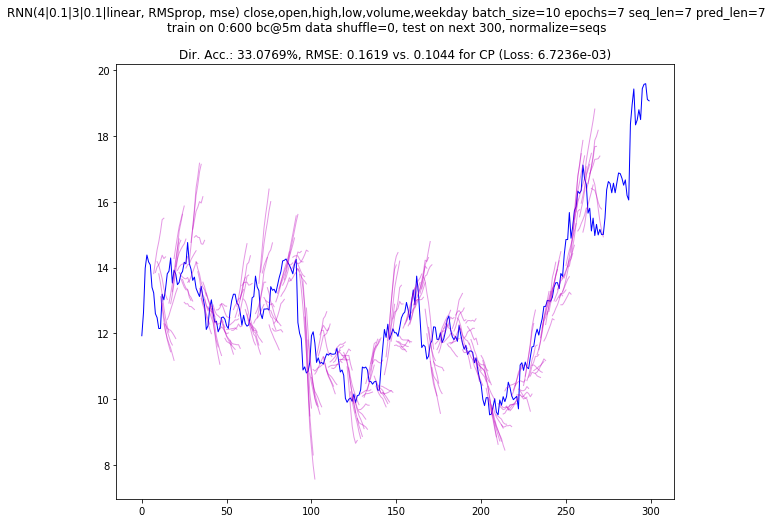

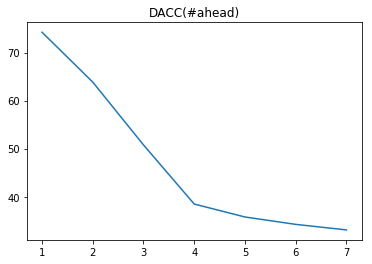

--- 58.977s to run segment

--- 58.977s to full run 600 - 645



        #################################
        # gbtc
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 6)
--- 0.043s to model compilation time


--- Created model id: 140536238445456
Tensor("lstm_355_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_355 (LSTM)              (None, 7, 4)              176       
_________________________________________________________________
dropout_355 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_356 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_356 (Dropout)        (None, 3)                 0         
_________________________

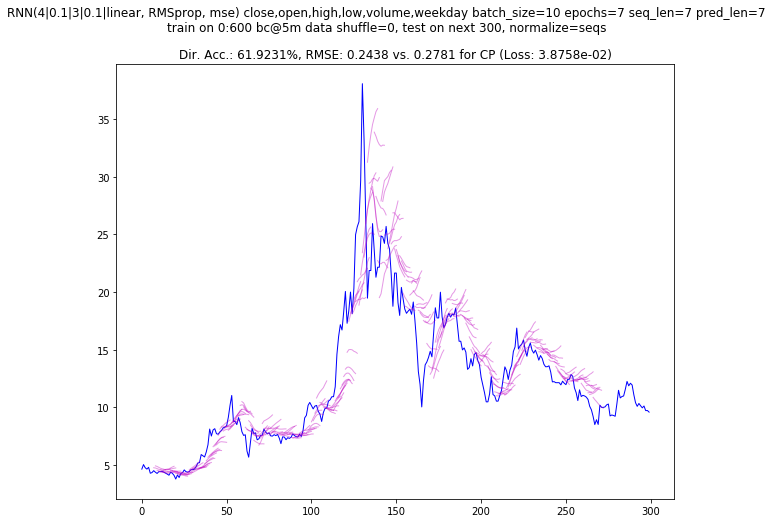

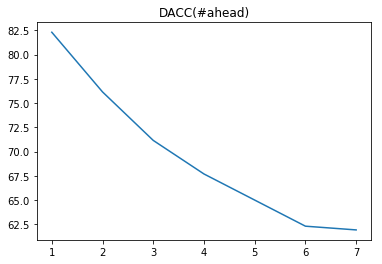

--- 59.143s to run segment

--- 59.143s to full run 600 - 645



        #################################
        # nvda
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 6)
--- 0.028s to model compilation time


--- Created model id: 140536217502416
Tensor("lstm_357_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_357 (LSTM)              (None, 7, 4)              176       
_________________________________________________________________
dropout_357 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_358 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_358 (Dropout)        (None, 3)                 0         
_________________________

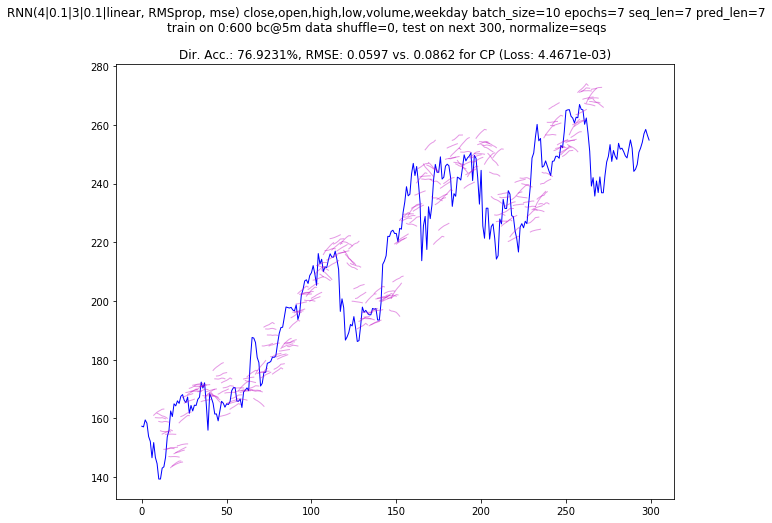

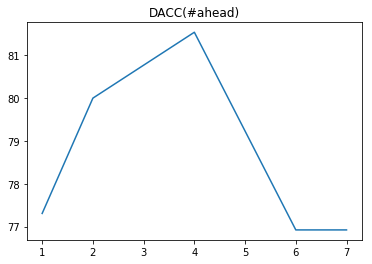

--- 56.991s to run segment

--- 56.992s to full run 600 - 645



        #################################
        # mara
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 6)
--- 0.020s to model compilation time


--- Created model id: 140536194493264
Tensor("lstm_359_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_359 (LSTM)              (None, 7, 4)              176       
_________________________________________________________________
dropout_359 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_360 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_360 (Dropout)        (None, 3)                 0         
_________________________

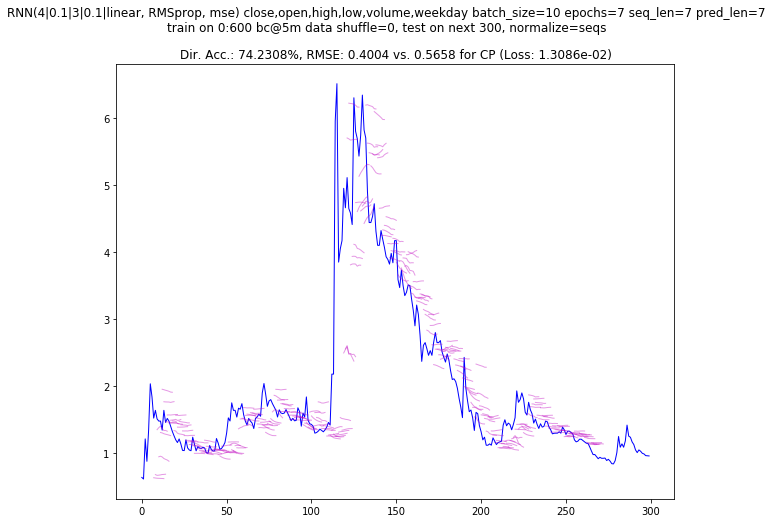

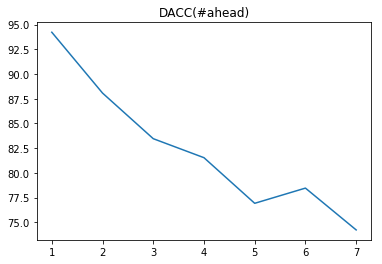

--- 56.041s to run segment

--- 56.041s to full run 600 - 645



        #################################
        # sieb
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 6)
--- 0.021s to model compilation time


--- Created model id: 140536170346000
Tensor("lstm_361_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_361 (LSTM)              (None, 7, 4)              176       
_________________________________________________________________
dropout_361 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_362 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_362 (Dropout)        (None, 3)                 0         
_________________________

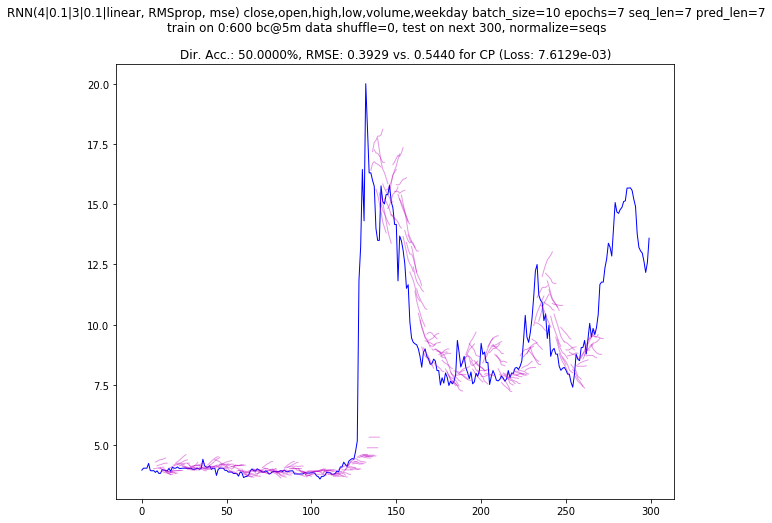

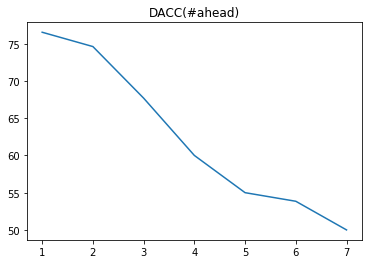

--- 56.807s to run segment

--- 56.807s to full run 600 - 645



        #################################
        # sp500
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 6)


AssertionError: nan != 0.000000

In [45]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    full_run(600, len(data) - 300, data,
             out_filename='./results/stock_%s_ohlcw.csv' % stock,
             write_csv_header=True)

In [48]:
results = {}
for stock in STOCKS:
    r = pd.read_csv('./results/stock_%s_ohlcw.csv' % stock)
    r['rmse'] = r['rmse'].str.replace('%', '').astype(float)
    r['rmse_cp'] = r['rmse_cp'].str.replace('%', '').astype(float)
    r['dir_acc'] = r['dir_acc'].str.replace('%', '').astype(float)
    print("\n\n---------")
    print("> stock %s: RMSE=%.4f%% (vs. %.4f%% for CP), DACC=%.2f%%" % (
        stock.upper(),
        r['rmse'].mean(), 
        r['rmse_cp'].mean(),
        r['dir_acc'].mean(),
    ))
    dd(r)
    results[stock] = r



---------
> stock SP500: RMSE=0.0260% (vs. 0.0272% for CP), DACC=47.69%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       600   

   test_on  shuffle normalize  training_loss   rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.000212  0.026   0.0272  47.6923



---------
> stock AMD: RMSE=0.1619% (vs. 0.1044% for CP), DACC=33.08%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.006724  0.1619   0.1044  33.0769



---------
> stock NVDA: RMSE=0.0597% (vs. 0.0862% for CP), DACC=76.92%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.004467  0.0597   0.0862  76.9231



---------
> stock GBTC: RMSE=0.2438% (vs. 0.2781% for CP), DACC=61.92%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.038758  0.2438   0.2781  61.9231



---------
> stock MARA: RMSE=0.4004% (vs. 0.5658% for CP), DACC=74.23%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.013086  0.4004   0.5658  74.2308



---------
> stock OSTK: RMSE=0.1676% (vs. 0.2261% for CP), DACC=70.77%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.003232  0.1676   0.2261  70.7692



---------
> stock OTIV: RMSE=0.2403% (vs. 0.2224% for CP), DACC=33.46%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close ba...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.005785  0.2403   0.2224  33.4615



---------
> stock RIOT: RMSE=0.3110% (vs. 0.4186% for CP), DACC=65.00%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss   rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.011827  0.311   0.4186     65.0



---------
> stock SIEB: RMSE=0.3929% (vs. 0.5440% for CP), DACC=50.00%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.007613  0.3929    0.544     50.0



        #################################
        # ostk
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.022s to model compilation time


--- Created model id: 140537467780304
Tensor("lstm_363_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_363 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_363 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_364 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_364 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_182 (Dense)     

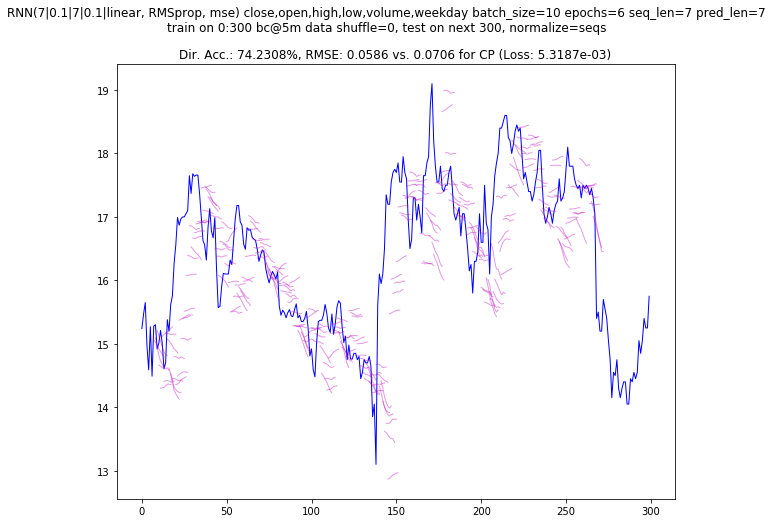

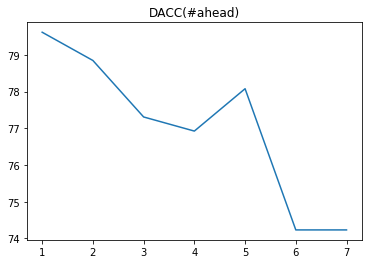

--- 66.923s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.036s to model compilation time


--- Created model id: 140536123569360
Tensor("lstm_365_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_365 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_365 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_366 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_366 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 8         
Total params: 820
Trainable params: 

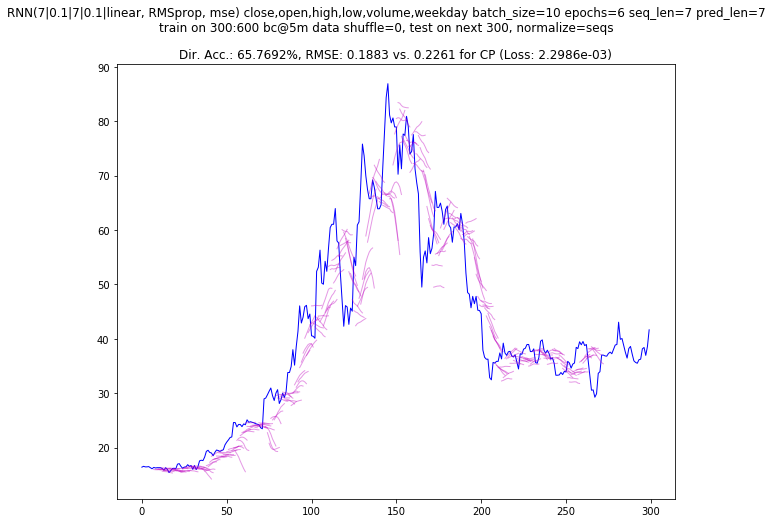

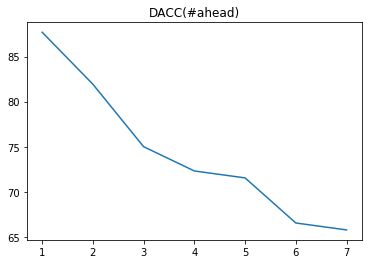

--- 55.179s to run segment

--- 122.103s to full run 300 - 645



        #################################
        # riot
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.023s to model compilation time


--- Created model id: 140536102654672
Tensor("lstm_367_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_367 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_367 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_368 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_368 (Dropout)        (None, 7)                 0         
________________________

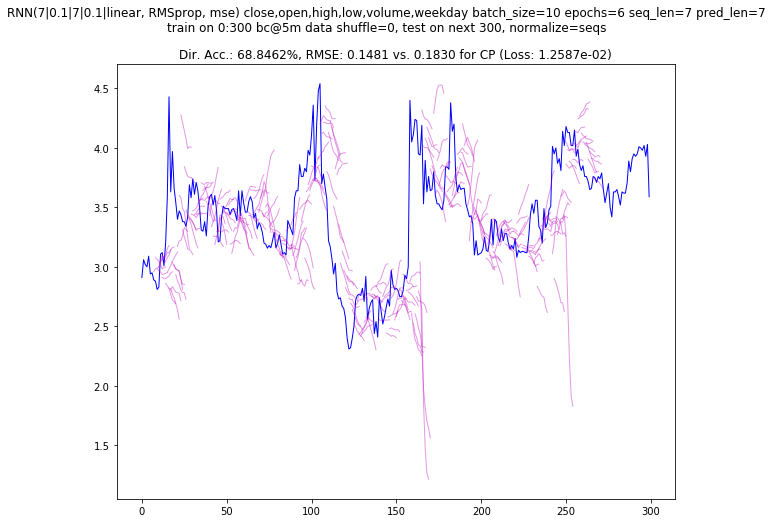

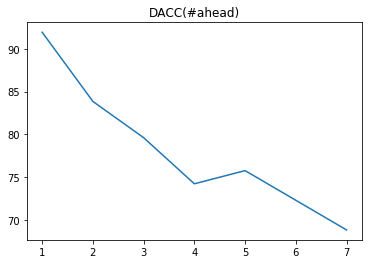

--- 54.315s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.023s to model compilation time


--- Created model id: 140536101598352
Tensor("lstm_369_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_369 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_369 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_370 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_370 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 8         
Total params: 820
Trainable params: 

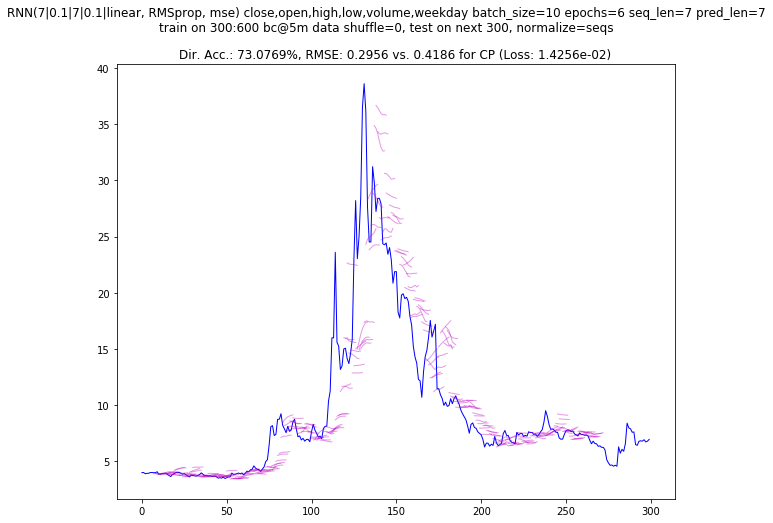

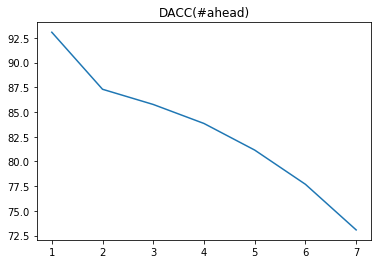

--- 54.959s to run segment

--- 109.275s to full run 300 - 645



        #################################
        # amd
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140536055410960
Tensor("lstm_371_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_371 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_371 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_372 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_372 (Dropout)        (None, 7)                 0         
_________________________

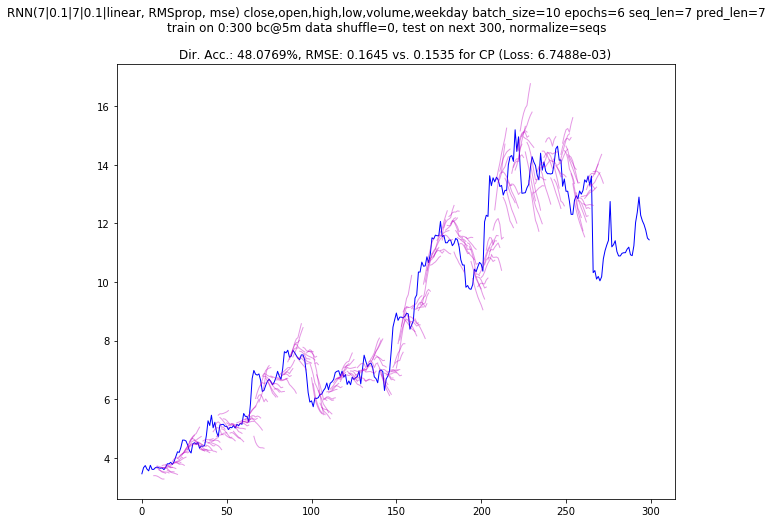

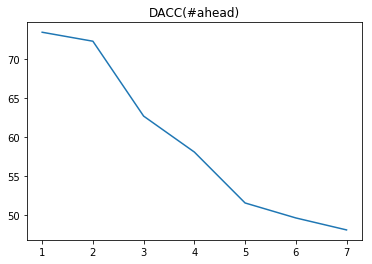

--- 55.207s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.023s to model compilation time


--- Created model id: 140536033095120
Tensor("lstm_373_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_373 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_373 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_374 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_374 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 8         
Total params: 820
Trainable params: 

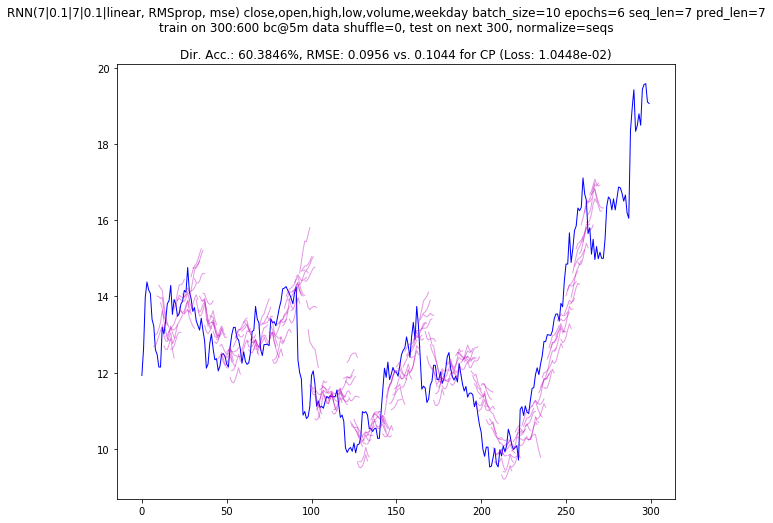

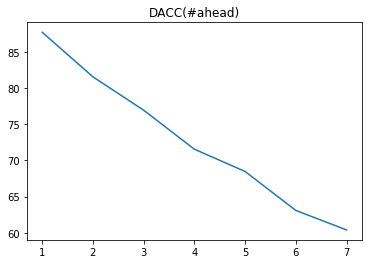

--- 55.370s to run segment

--- 110.577s to full run 300 - 645



        #################################
        # gbtc
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140536010117712
Tensor("lstm_375_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_375 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_375 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_376 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_376 (Dropout)        (None, 7)                 0         
________________________

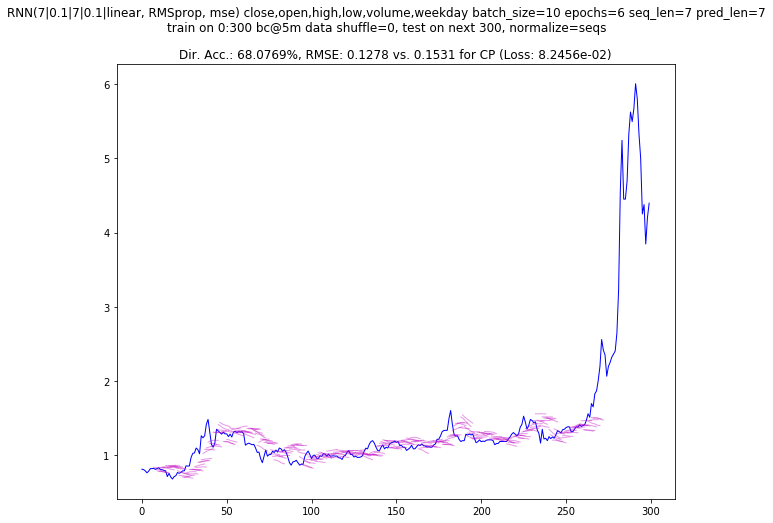

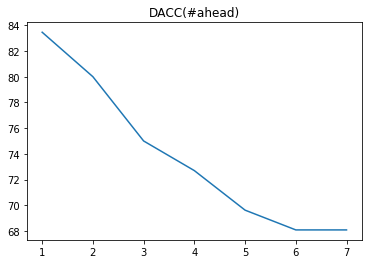

--- 55.601s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140535987070608
Tensor("lstm_377_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_377 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_377 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_378 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_378 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_189 (Dense)            (None, 1)                 8         
Total params: 820
Trainable params: 

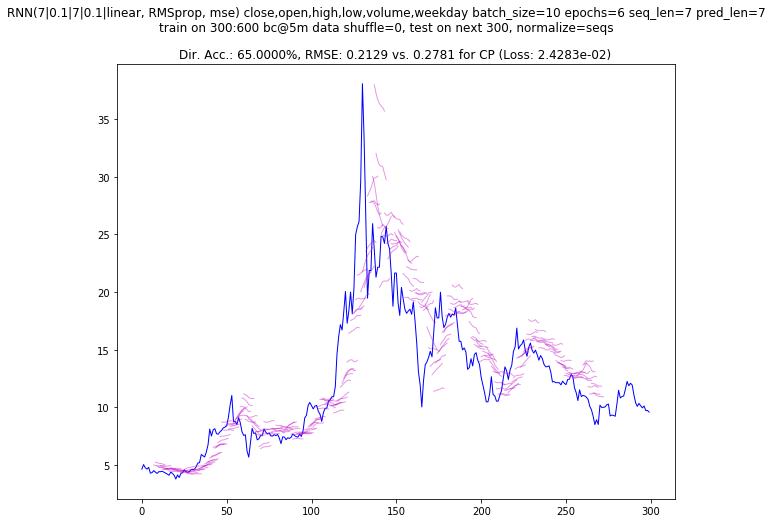

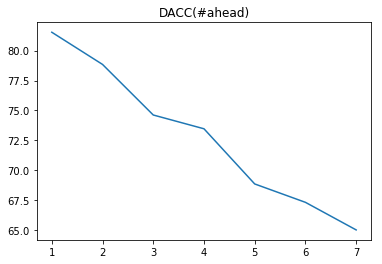

--- 56.816s to run segment

--- 112.417s to full run 300 - 645



        #################################
        # nvda
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.023s to model compilation time


--- Created model id: 140535966173712
Tensor("lstm_379_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_379 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_379 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_380 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_380 (Dropout)        (None, 7)                 0         
________________________

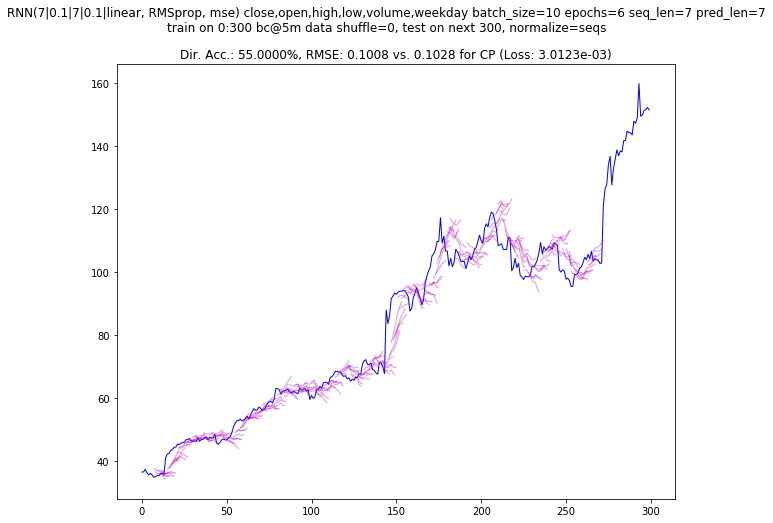

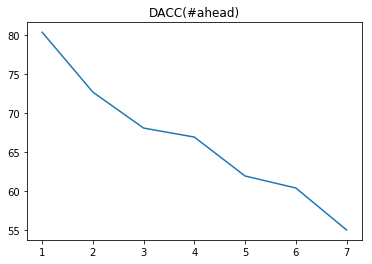

--- 57.643s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.020s to model compilation time


--- Created model id: 140535942258448
Tensor("lstm_381_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_381 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_381 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_382 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_382 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 8         
Total params: 820
Trainable params: 

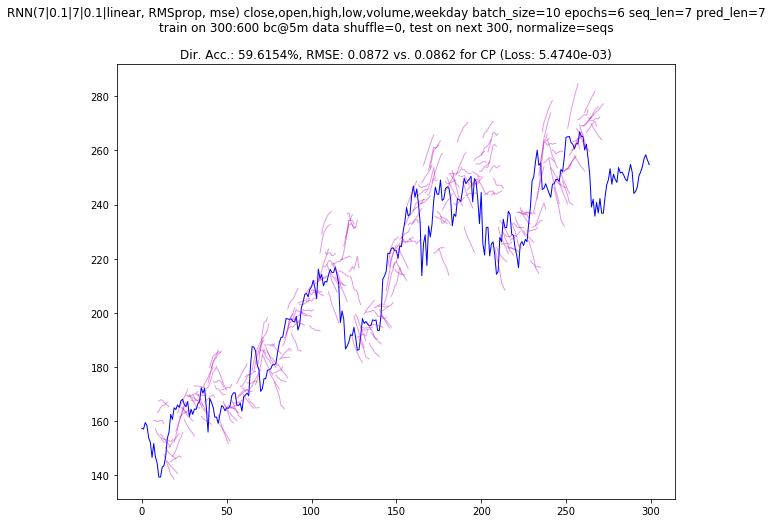

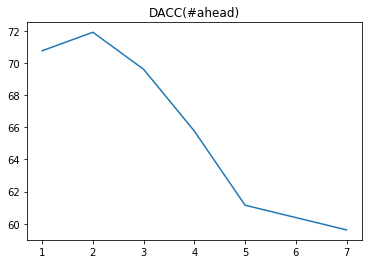

--- 57.854s to run segment

--- 115.498s to full run 300 - 645



        #################################
        # mara
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.026s to model compilation time


--- Created model id: 140535919653392
Tensor("lstm_383_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_383 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_383 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_384 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_384 (Dropout)        (None, 7)                 0         
________________________

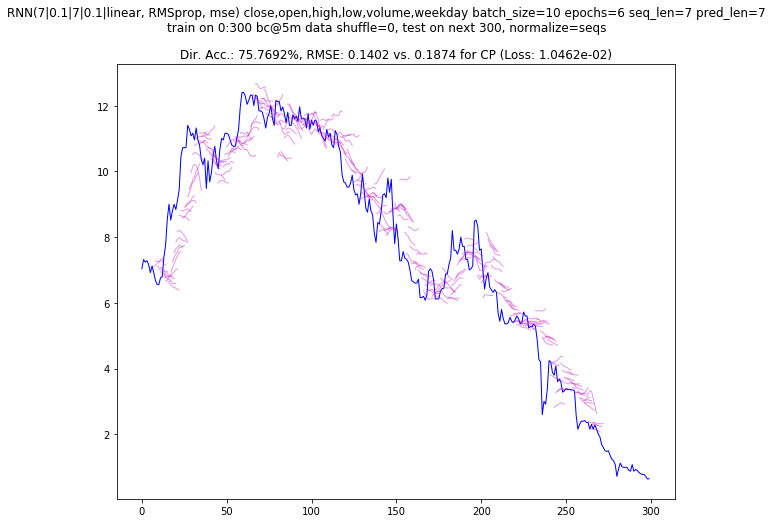

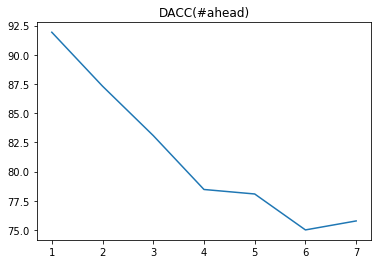

--- 291.766s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.042s to model compilation time


--- Created model id: 140536122727056
Tensor("lstm_385_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_385 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_385 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_386 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_386 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 8         
Total params: 820
Trainable params:

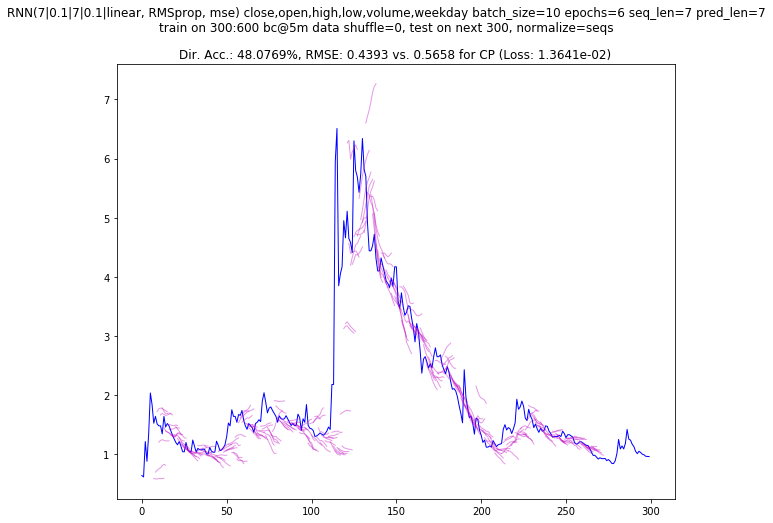

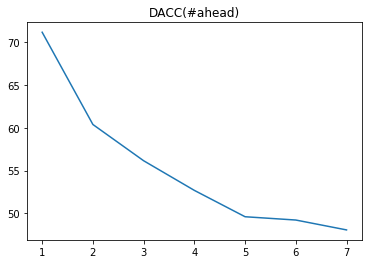

--- 62.347s to run segment

--- 354.117s to full run 300 - 645



        #################################
        # sieb
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.033s to model compilation time


--- Created model id: 140536671315152
Tensor("lstm_387_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_387 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_387 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_388 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_388 (Dropout)        (None, 7)                 0         
________________________

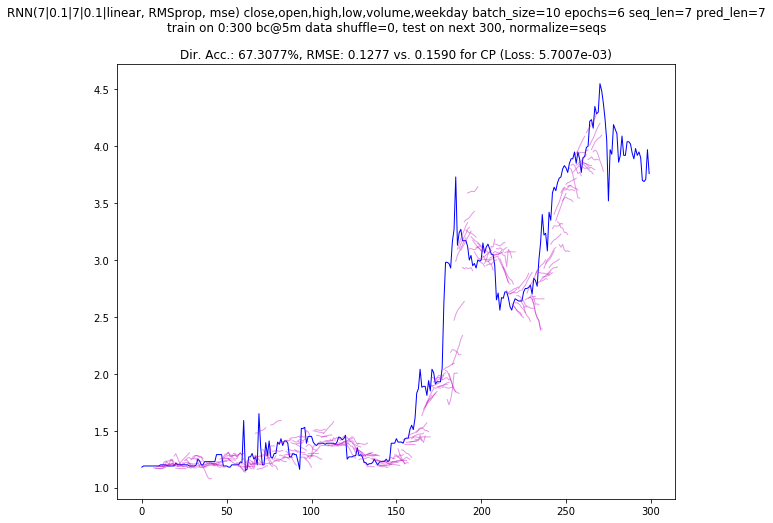

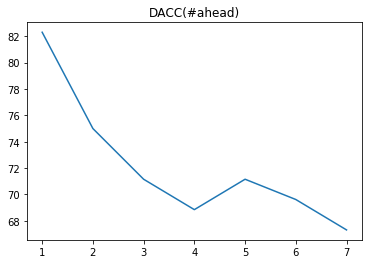

--- 67.537s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.037s to model compilation time


--- Created model id: 140536194517584
Tensor("lstm_389_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_389 (LSTM)              (None, 7, 7)              392       
_________________________________________________________________
dropout_389 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_390 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_390 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 8         
Total params: 820
Trainable params: 

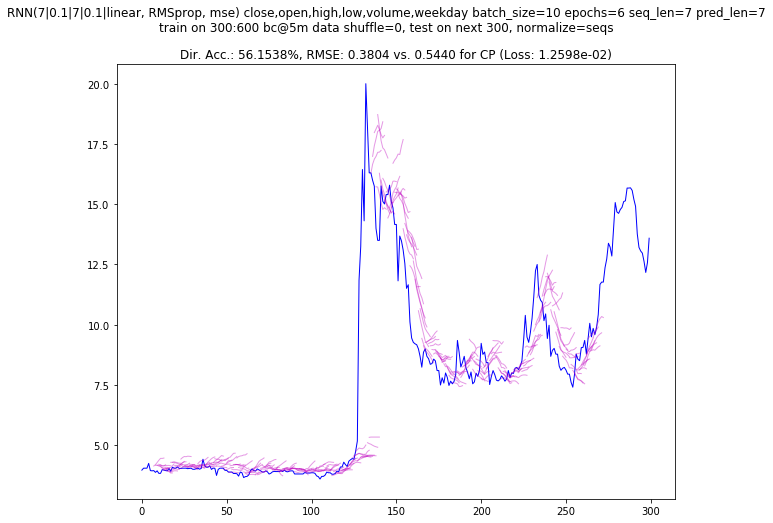

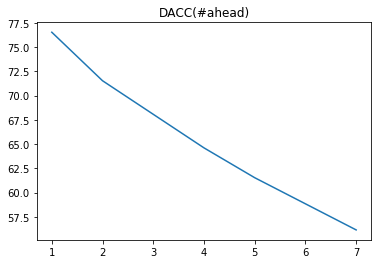

--- 63.154s to run segment

--- 130.694s to full run 300 - 645



        #################################
        # sp500
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)


AssertionError: nan != 0.000000

In [49]:
DEFAULT_PARAMS = {
    # data to extract:
    'features': ['close', 'open', 'high', 'low', 'volume',
                 'weekday'],
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([7, 0.1, 7, 0.1]),
    # training:
    'epochs': 6,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}



In [51]:
results2 = {}
for stock in STOCKS:
    r = pd.read_csv('./results/stock_%s_ohlcw2.csv' % stock)
    r['rmse'] = r['rmse'].str.replace('%', '').astype(float)
    r['rmse_cp'] = r['rmse_cp'].str.replace('%', '').astype(float)
    r['dir_acc'] = r['dir_acc'].str.replace('%', '').astype(float)
    print("\n\n---------")
    print("> stock %s: RMSE=%.4f%% (vs. %.4f%% for CP), DACC=%.2f%%" % (
        stock.upper(),
        r['rmse'].mean(), 
        r['rmse_cp'].mean(),
        r['dir_acc'].mean(),
    ))
    dd(r)
    results2[stock] = r



---------
> stock SP500: RMSE=nan% (vs. nan% for CP), DACC=nan%


Empty DataFrame
Columns: [model_description, train_from, train_to, test_on, shuffle, normalize, training_loss, rmse, rmse_cp, dir_acc]
Index: []



---------
> stock AMD: RMSE=0.1300% (vs. 0.1290% for CP), DACC=54.23%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.006749  0.1645   0.1535  48.0769  
1      300    False      seqs       0.010448  0.0956   0.1044  60.3846



---------
> stock NVDA: RMSE=0.0940% (vs. 0.0945% for CP), DACC=57.31%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.003012  0.1008   0.1028  55.0000  
1      300    False      seqs       0.005474  0.0872   0.0862  59.6154



---------
> stock GBTC: RMSE=0.1704% (vs. 0.2156% for CP), DACC=66.54%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.082456  0.1278   0.1531  68.0769  
1      300    False      seqs       0.024283  0.2129   0.2781  65.0000



---------
> stock MARA: RMSE=0.2898% (vs. 0.3766% for CP), DACC=61.92%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.010462  0.1402   0.1874  75.7692  
1      300    False      seqs       0.013641  0.4393   0.5658  48.0769



---------
> stock OSTK: RMSE=0.1235% (vs. 0.1483% for CP), DACC=70.00%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.005319  0.0586   0.0706  74.2308  
1      300    False      seqs       0.002299  0.1883   0.2261  65.7692



---------
> stock OTIV: RMSE=nan% (vs. nan% for CP), DACC=nan%


Empty DataFrame
Columns: [model_description, train_from, train_to, test_on, shuffle, normalize, training_loss, rmse, rmse_cp, dir_acc]
Index: []



---------
> stock RIOT: RMSE=0.2218% (vs. 0.3008% for CP), DACC=70.96%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.012587  0.1481   0.1830  68.8462  
1      300    False      seqs       0.014256  0.2956   0.4186  73.0769



---------
> stock SIEB: RMSE=0.2540% (vs. 0.3515% for CP), DACC=61.73%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.005701  0.1277    0.159  67.3077  
1      300    False      seqs       0.012598  0.3804    0.544  56.1538



        #################################
        # ostk
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.014s to model compilation time


--- Created model id: 140213355443088
Tensor("lstm_1_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 3)              120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 3)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dropout_2 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)         

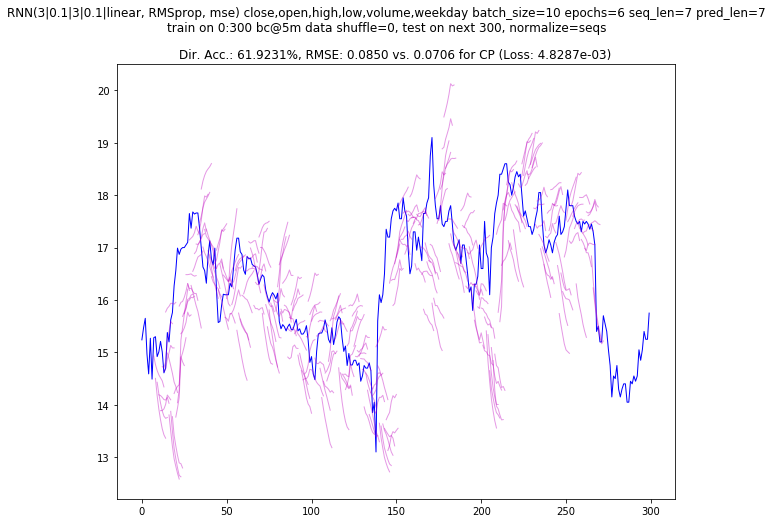

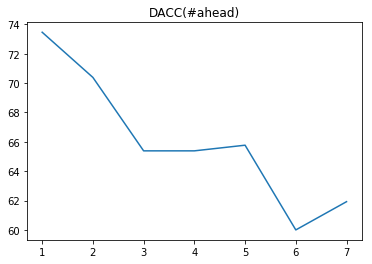

--- 5.186s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.014s to model compilation time


--- Created model id: 140212436386256
Tensor("lstm_3_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 3)              120       
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 3)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dropout_4 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 208
Trainable params: 208

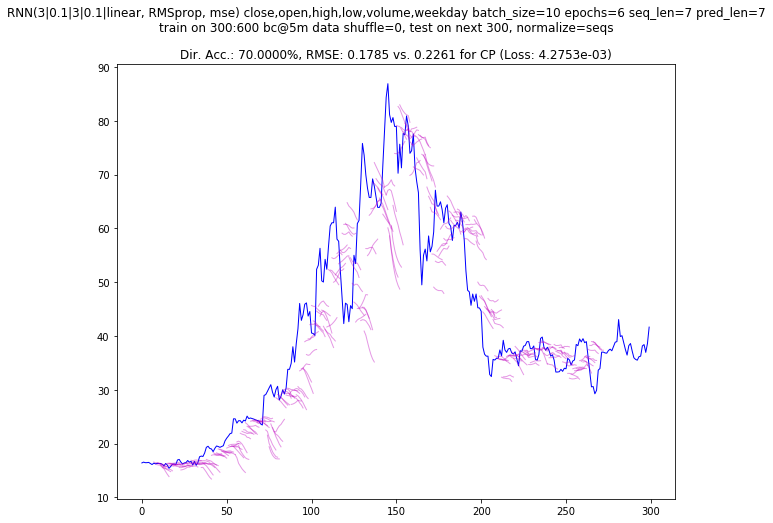

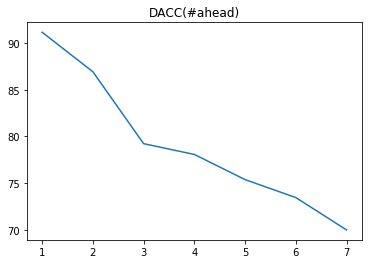

--- 4.870s to run segment

--- 10.056s to full run 300 - 645



        #################################
        # riot
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.014s to model compilation time


--- Created model id: 140211776604496
Tensor("lstm_5_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 3)              120       
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 3)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dropout_6 (Dropout)          (None, 3)                 0         
____________________________

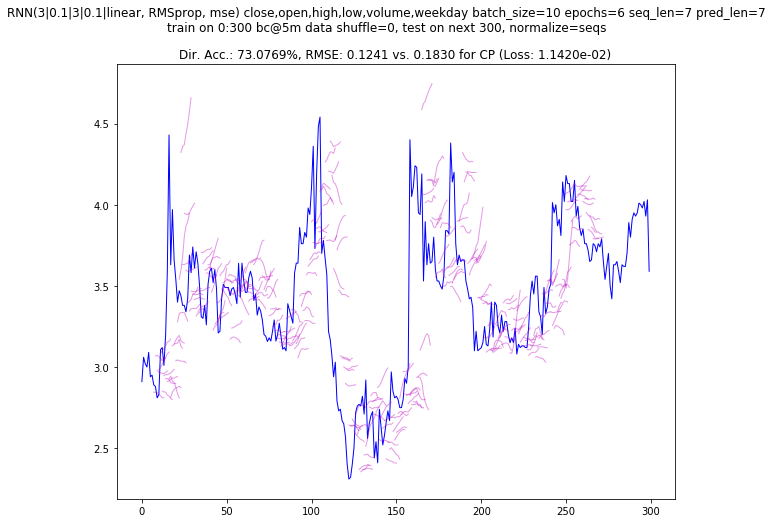

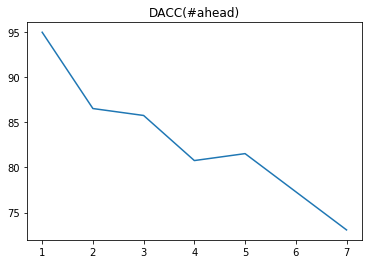

--- 4.959s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.013s to model compilation time


--- Created model id: 140211758662288
Tensor("lstm_7_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 7, 3)              120       
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 3)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dropout_8 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 208
Trainable params: 208

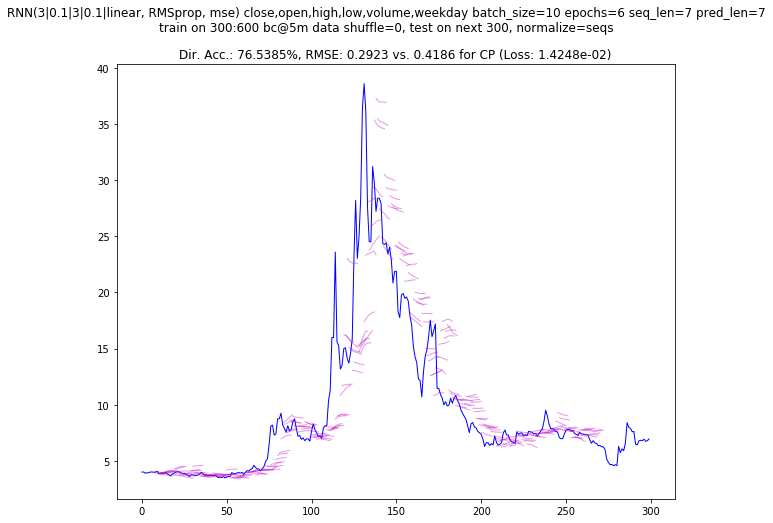

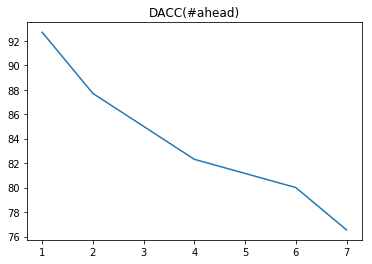

--- 5.649s to run segment

--- 10.608s to full run 300 - 645



        #################################
        # amd
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.014s to model compilation time


--- Created model id: 140211674380816
Tensor("lstm_9_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 7, 3)              120       
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 3)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_10 (Dropout)         (None, 3)                 0         
_____________________________

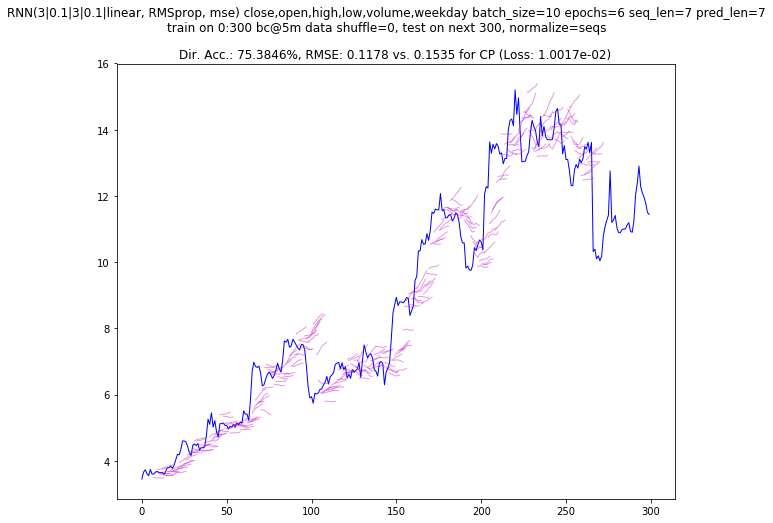

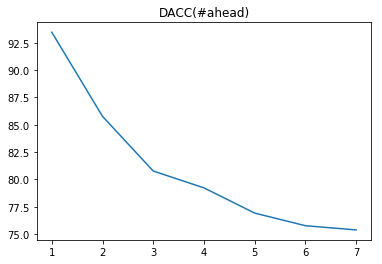

--- 5.892s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140211656526288
Tensor("lstm_11_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_12 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 208
Trainable params: 20

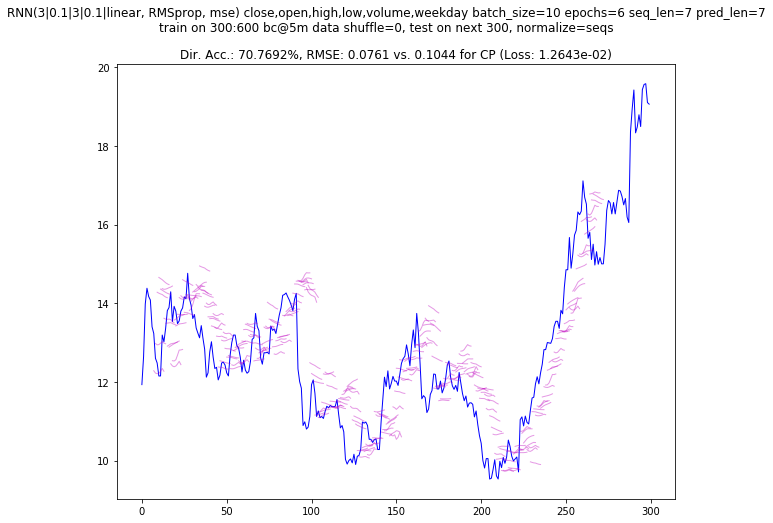

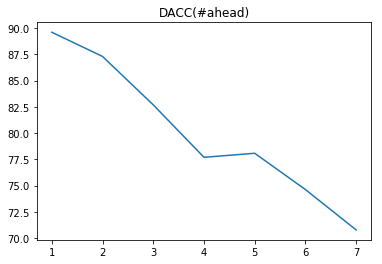

--- 6.286s to run segment

--- 12.179s to full run 300 - 645



        #################################
        # gbtc
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140211637161424
Tensor("lstm_13_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_14 (Dropout)         (None, 3)                 0         
___________________________

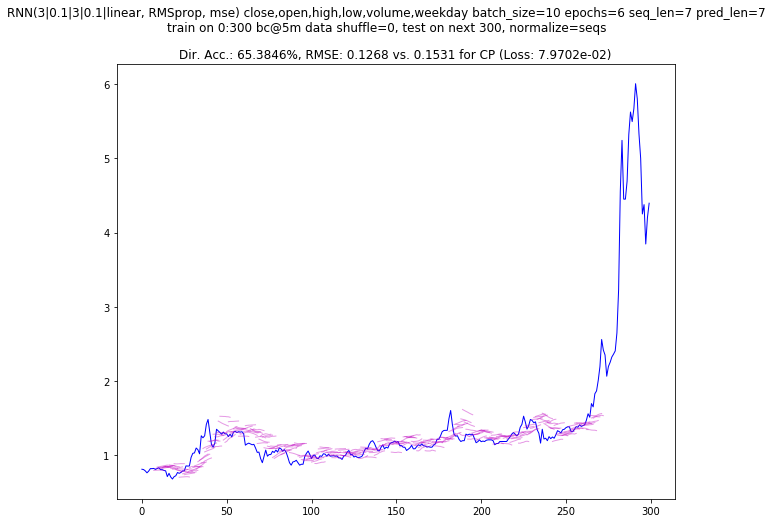

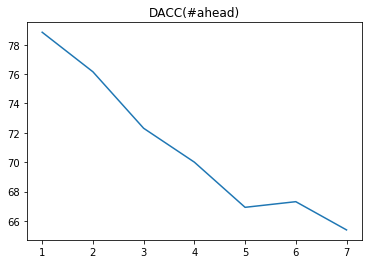

--- 6.941s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140211621030416
Tensor("lstm_15_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_16 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 4         
Total params: 208
Trainable params: 20

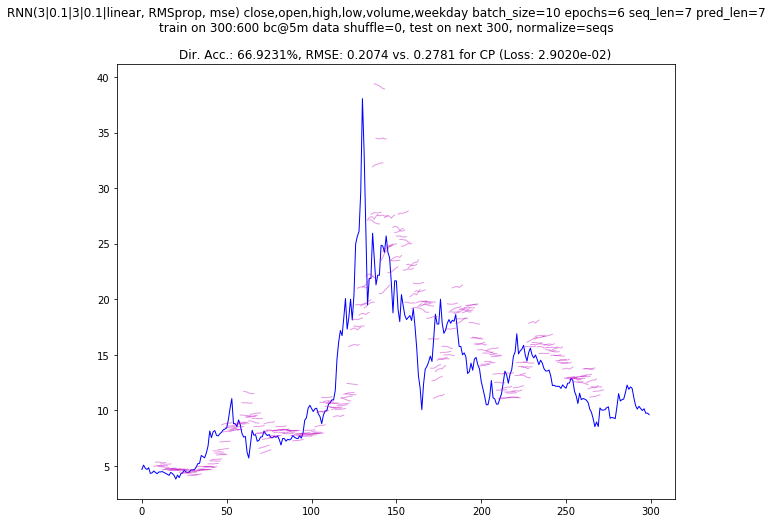

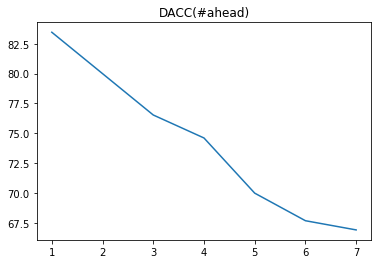

--- 6.386s to run segment

--- 13.327s to full run 300 - 645



        #################################
        # nvda
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140211596822736
Tensor("lstm_17_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_18 (Dropout)         (None, 3)                 0         
___________________________

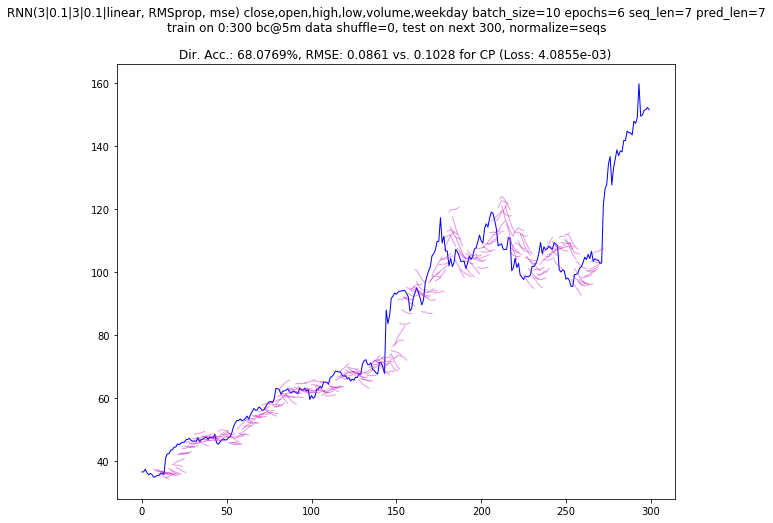

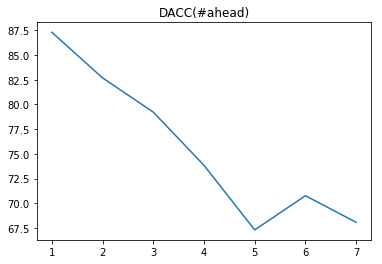

--- 6.863s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140211586071888
Tensor("lstm_19_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_20 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 4         
Total params: 208
Trainable params: 20

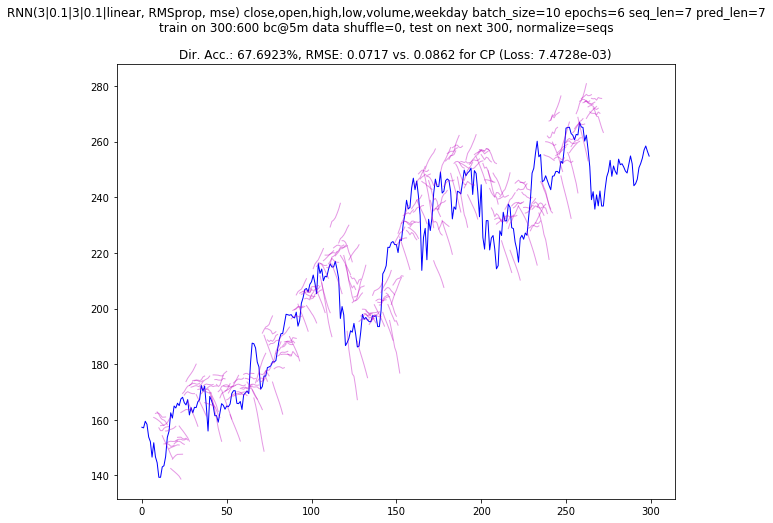

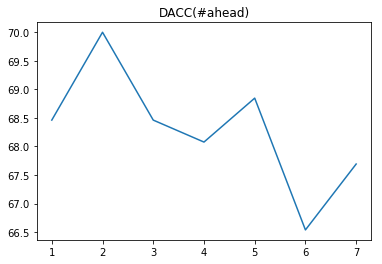

--- 6.865s to run segment

--- 13.728s to full run 300 - 645



        #################################
        # mara
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140211555663312
Tensor("lstm_21_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_22 (Dropout)         (None, 3)                 0         
___________________________

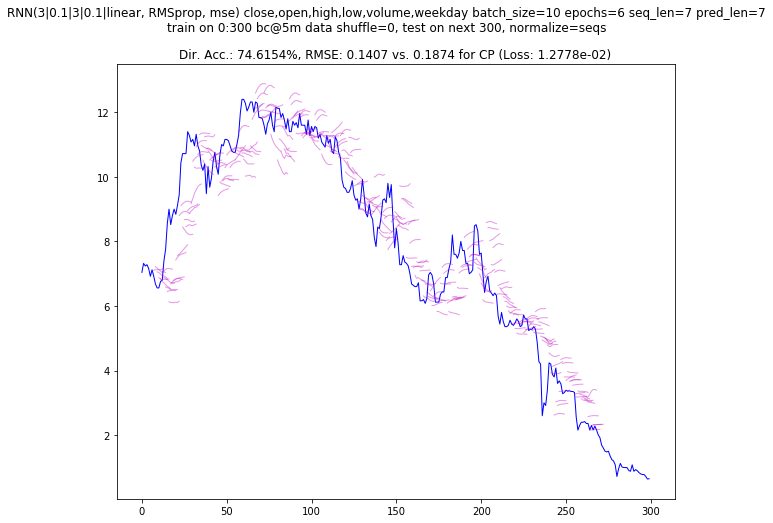

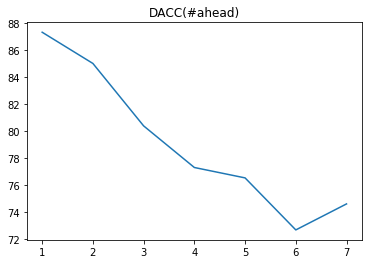

--- 7.567s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140211541526736
Tensor("lstm_23_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_24 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 4         
Total params: 208
Trainable params: 20

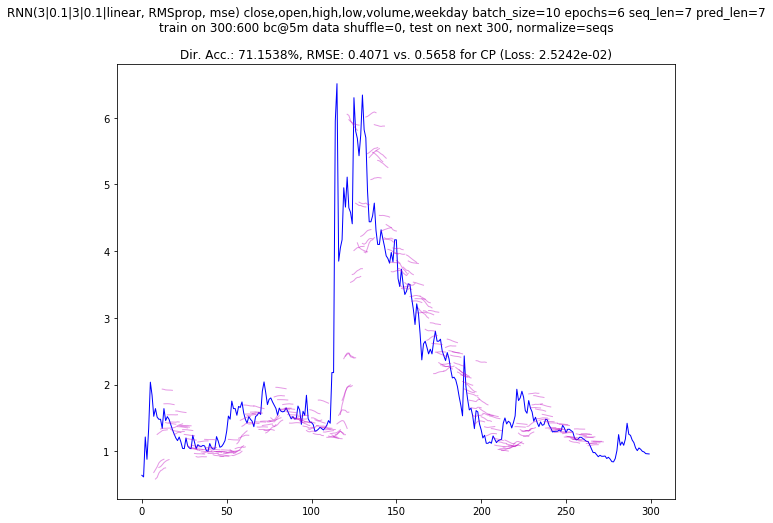

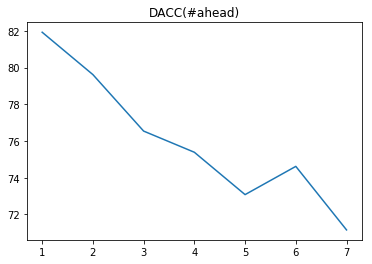

--- 7.005s to run segment

--- 14.573s to full run 300 - 645



        #################################
        # sieb
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140211519798672
Tensor("lstm_25_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_26 (Dropout)         (None, 3)                 0         
___________________________

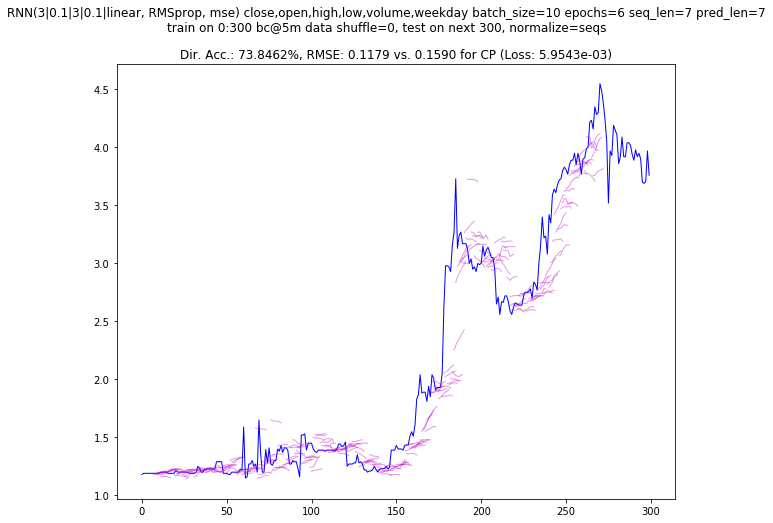

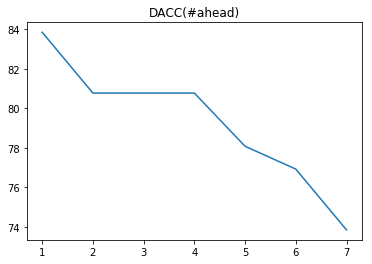

--- 7.833s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.017s to model compilation time


--- Created model id: 140211520265616
Tensor("lstm_27_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_28 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 4         
Total params: 208
Trainable params: 20

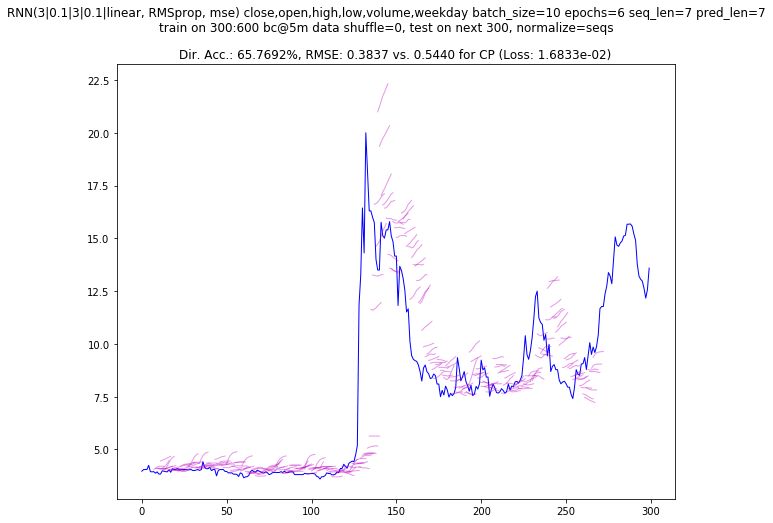

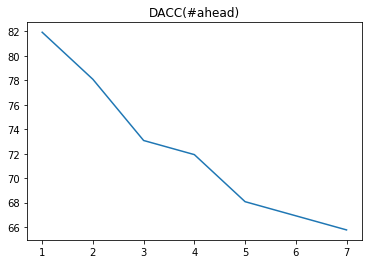

--- 7.977s to run segment

--- 15.810s to full run 300 - 645



        #################################
        # sp500
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)


AssertionError: nan != 0.000000

In [11]:
DEFAULT_PARAMS = {
    # data to extract:
    'features': ['close', 'open', 'high', 'low', 'volume',
                 'weekday'],
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([3, 0.1, 3, 0.1]),
    # training:
    'epochs': 6,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    full_run(300, len(data) - 300, data,
             out_filename='./results/stock_%s_ohlcw3.csv' % stock,
             write_csv_header=True)

In [12]:
results3 = {}
for stock in STOCKS:
    r = pd.read_csv('./results/stock_%s_ohlcw2.csv' % stock)
    r['rmse'] = r['rmse'].str.replace('%', '').astype(float)
    r['rmse_cp'] = r['rmse_cp'].str.replace('%', '').astype(float)
    r['dir_acc'] = r['dir_acc'].str.replace('%', '').astype(float)
    print("\n\n---------")
    print("> stock %s: RMSE=%.4f%% (vs. %.4f%% for CP), DACC=%.2f%%" % (
        stock.upper(),
        r['rmse'].mean(), 
        r['rmse_cp'].mean(),
        r['dir_acc'].mean(),
    ))
    dd(r)
    results3[stock] = r



---------
> stock SP500: RMSE=nan% (vs. nan% for CP), DACC=nan%


Empty DataFrame
Columns: [model_description, train_from, train_to, test_on, shuffle, normalize, training_loss, rmse, rmse_cp, dir_acc]
Index: []



---------
> stock AMD: RMSE=0.1300% (vs. 0.1290% for CP), DACC=54.23%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.006749  0.1645   0.1535  48.0769  
1      300    False      seqs       0.010448  0.0956   0.1044  60.3846



---------
> stock NVDA: RMSE=0.0940% (vs. 0.0945% for CP), DACC=57.31%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.003012  0.1008   0.1028  55.0000  
1      300    False      seqs       0.005474  0.0872   0.0862  59.6154



---------
> stock GBTC: RMSE=0.1704% (vs. 0.2156% for CP), DACC=66.54%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.082456  0.1278   0.1531  68.0769  
1      300    False      seqs       0.024283  0.2129   0.2781  65.0000



---------
> stock MARA: RMSE=0.2898% (vs. 0.3766% for CP), DACC=61.92%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.010462  0.1402   0.1874  75.7692  
1      300    False      seqs       0.013641  0.4393   0.5658  48.0769



---------
> stock OSTK: RMSE=0.1235% (vs. 0.1483% for CP), DACC=70.00%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.005319  0.0586   0.0706  74.2308  
1      300    False      seqs       0.002299  0.1883   0.2261  65.7692



---------
> stock OTIV: RMSE=nan% (vs. nan% for CP), DACC=nan%


Empty DataFrame
Columns: [model_description, train_from, train_to, test_on, shuffle, normalize, training_loss, rmse, rmse_cp, dir_acc]
Index: []



---------
> stock RIOT: RMSE=0.2218% (vs. 0.3008% for CP), DACC=70.96%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.012587  0.1481   0.1830  68.8462  
1      300    False      seqs       0.014256  0.2956   0.4186  73.0769



---------
> stock SIEB: RMSE=0.2540% (vs. 0.3515% for CP), DACC=61.73%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.005701  0.1277    0.159  67.3077  
1      300    False      seqs       0.012598  0.3804    0.544  56.1538